### Functions

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
from itertools import combinations
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import sys
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Dynamic Time Warping
#!pip install dtw-python
#from dtw import *

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import kpss
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf
# from statsmodels.tsa.stattools import ccf
# from statsmodels.tsa.stattools import acf
# from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.sandbox.stats.multicomp import MultiComparison

# Sklearn
# from sklearn.decomposition import PCA
# from sklearn.cluster import *
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
# from sklearn.model_selection import ParameterGrid
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import *
# from sklearn.feature_extraction import  *
# from sklearn.base import *
# from sklearn.model_selection import *
# from sklearn.linear_model import *
# from sklearn.model_selection import *
# from sklearn.metrics import *
# from sklearn.svm import *
# from sklearn.pipeline import *
# from sklearn.preprocessing import *
# from sklearn.feature_selection import *
# from sklearn.neighbors import *
# from imblearn.over_sampling import *
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.ensemble import *
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import balanced_accuracy_score
import random

# Scipy
from scipy.stats import *
from scipy.interpolate import make_interp_spline

# Warnings
import warnings

# Prophet
!python -m pip install prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from dask.distributed import Client

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # Drive path
  %cd $drive_path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price, fig_size = (10, 5)):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price,fig_size = (10, 5)):

  df = df.copy()

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price, fig_size = (10, 5)):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro", fig_size = (10, 5)):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price, fig_size)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price, fig_size)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price, fig_size)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = confint
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Convert data to features

In [ ]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=True):
	
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  data = list(data)
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

##### Save figure

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Basic_models

- **Goal**: implementation of simple models for short-term prediction of individual time series

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


### Get data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
# df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
# df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

# counts = []
# for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#   counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(counts)
# #ax.set_yscale('log')
# plt.title("Nº of examples that have more than a certain number of changes");

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

### Visualize data

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[800]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  327


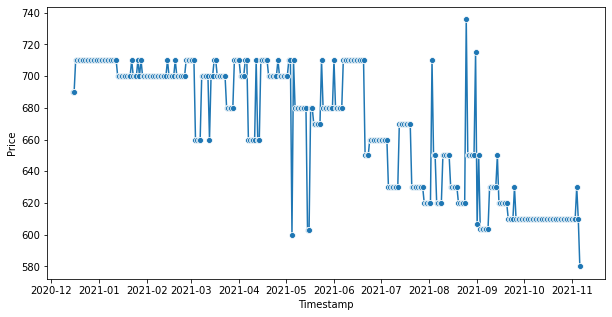

In [ ]:
product_id = [product_id_ord_fill[11]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o').set(xlabel='Timestamp', ylabel='Price')
if len(product_id) == 1:
  #ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))
#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

Number of samples:  133


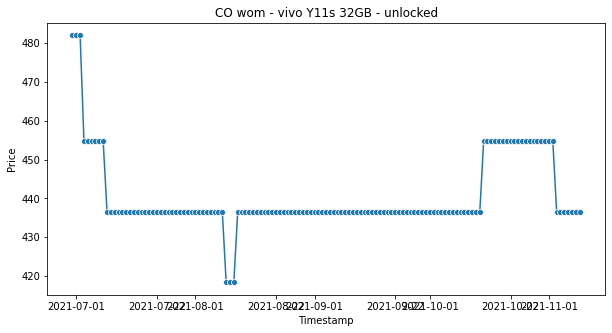

In [ ]:
product_id = [product_id_ord_fill[1000]]
#product_id = [1124]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o')
ax.set(xlabel='Timestamp', ylabel='Price')

if len(product_id) == 1:
  ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))

#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

In [ ]:
show_time_series(df_product, "product_id", info)

KeyError: ignored

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

In [ ]:
#product_id = [product_id_ord_fill[800]]
product_id = 1124

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

### Prophet

#### Basic example

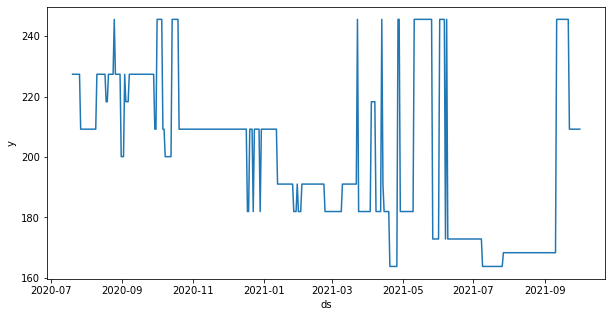

In [ ]:
i = 28
data = pd.DataFrame(df_all.loc[i].price_euro).reset_index()
data.columns = ["ds", "y"]
set_fig_size((10, 5))
sns.lineplot(data = data, x = "ds", y = "y")

In [ ]:
# Very low flexibility
m1 = Prophet(changepoint_prior_scale=0.005, weekly_seasonality = True)
m1.add_seasonality(name='weekly', period=7, fourier_order=5)
m1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m1.fit(data)
future = m1.make_future_dataframe(periods=50)
future.tail()
forecast1 = m1.predict(future)

# Very high flexibility
m2 = Prophet(changepoint_prior_scale=0.5, weekly_seasonality = True)
m2.add_seasonality(name='weekly', period=7, fourier_order=25)
m2.add_seasonality(name='monthly', period=30.5, fourier_order=25)

m2.fit(data)
future = m2.make_future_dataframe(periods=50)
future.tail()
forecast2 = m2.predict(future)

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_examplesHighLowFlexibility.


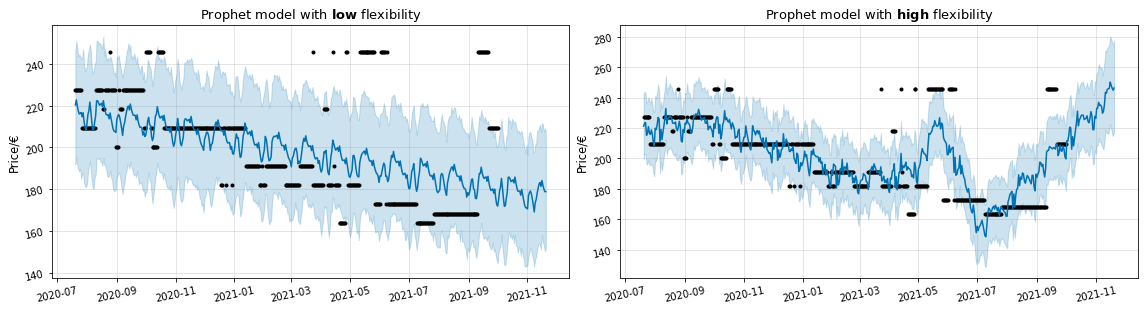

In [ ]:
fontsize = 13
set_fig_size((16, 4.5))
fig, ax = plt.subplots(1, 2)

m1.plot(forecast1, ax = ax[0]);
ax[0].set_title("Prophet model with " + r"$\bf{low}$" + " flexibility", fontsize = fontsize)
ax[0].set_xlabel("")
ax[0].set_ylabel("Price/€", fontsize = fontsize -1.5)
ax[0].tick_params(labelrotation=12)

m2.plot(forecast2, ax = ax[1]);
ax[1].set_title("Prophet model with " + r"$\bf{high}$" + " flexibility", fontsize = fontsize)
ax[1].set_xlabel("")
ax[1].set_ylabel("Price/€", fontsize = fontsize - 1.5)
ax[1].tick_params(labelrotation=12)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "examplesHighLowFlexibility")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_modelComponents.


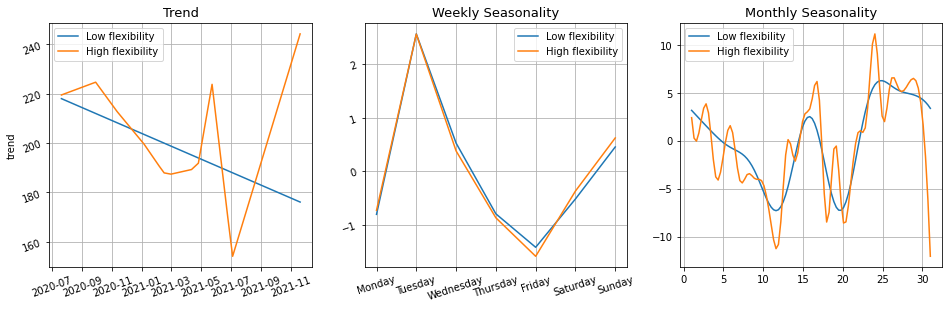

In [ ]:
fontsize = 13

set_fig_size((16, 4.5))
fig, ax = plt.subplots(1,3)

# Trend
sns.lineplot(data = forecast1[["ds", "trend"]], x = "ds", y = "trend", ax = ax[0], label = "Low flexibility")
sns.lineplot(data = forecast2[["ds", "trend"]], x = "ds", y = "trend", ax = ax[0], label = "High flexibility")
ax[0].grid() 
ax[0].tick_params(labelrotation=20)
ax[0].set_title("Trend", fontsize = fontsize)
ax[0].set_xlabel("")
ax[1].set_ylabel("")

# Weekly sasonality
weekly1 = forecast1[["ds", "weekly"]].iloc[:7]
weekly2 = forecast2[["ds", "weekly"]].iloc[:7]
weekly1["ds"] = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 
weekly2["ds"] = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.lineplot(data = weekly1, x = "ds", y = "weekly", ax = ax[1], label = "Low flexibility")
sns.lineplot(data = weekly2, x = "ds", y = "weekly", ax = ax[1], label = "High flexibility")
ax[1].grid()
ax[1].tick_params(labelrotation=18)
ax[1].set_title("Weekly Seasonality", fontsize = fontsize)
ax[1].set_xlabel("")
ax[1].set_ylabel("")

# Monthly sasonality
monthly1 = forecast1[["ds", "monthly"]].iloc[:30]
monthly2 = forecast2[["ds", "monthly"]].iloc[:30]
monthly1["ds"] = range(1, 31)
monthly2["ds"] = range(1, 31)

xnew1 = np.linspace(1, 31, 100)
gfg = make_interp_spline(monthly1["ds"], monthly1["monthly"], k=3)
y_new1 = gfg(xnew1)
monthly1 = pd.DataFrame([xnew1, y_new1]).T
monthly1.columns = ["ds", "monthly"]

xnew2 = np.linspace(1, 31, 100)
gfg = make_interp_spline(monthly2["ds"], monthly2["monthly"], k=3)
y_new2 = gfg(xnew2)
monthly2 = pd.DataFrame([xnew2, y_new2]).T
monthly2.columns = ["ds", "monthly"]

sns.lineplot(data = monthly1, x = "ds", y = "monthly", ax = ax[2], label = "Low flexibility")
sns.lineplot(data = monthly2, x = "ds", y = "monthly", ax = ax[2], label = "High flexibility")
ax[2].grid()
ax[2].set_title("Monthly Seasonality", fontsize = fontsize)
ax[2].set_xlabel("")
ax[2].set_ylabel("")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "modelComponents")

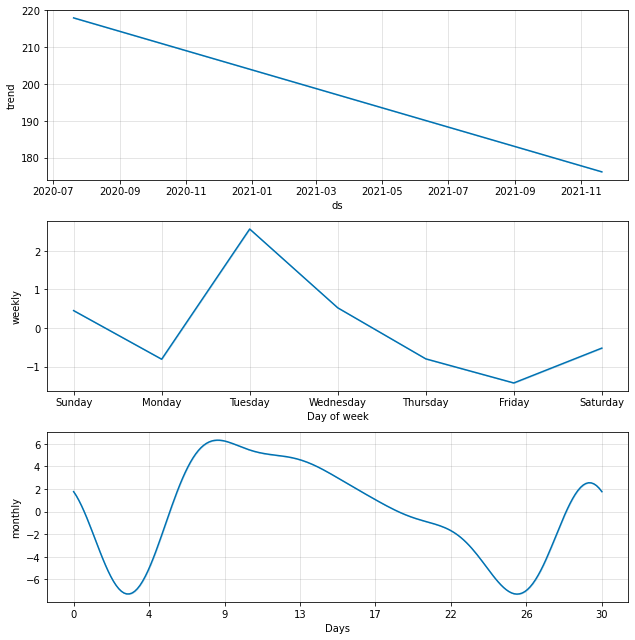

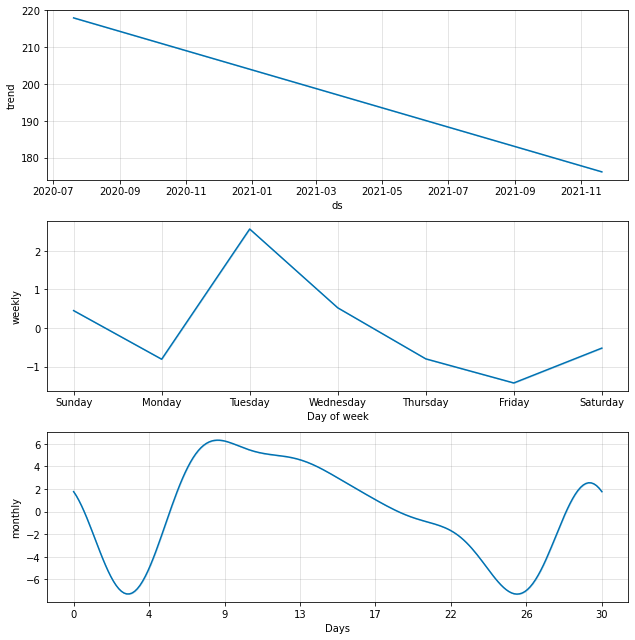

In [ ]:
m1.plot_components(forecast1)

#### Univariate

###### Functions

In [ ]:
def get_features_df_product_group_id(df, feature_types, max_lag, min_lag = 1):

  # Lag timeseries
  for feature_type in feature_types:
    for lag in range(min_lag, max_lag+1):
      df[feature_type + "_lag_" + str(lag)] = df.groupby(by = "product_id")[feature_type].shift(lag)

  df = df.dropna()

  # Missing values
  df["price_euro_mv"] = df["price_euro"].where(df["out_of_stock"] == 0, np.nan) 

  return df

def create_prophet_model(data, hyper_parameters, country, regressors = []):
  
  m = Prophet(changepoint_prior_scale = hyper_parameters["changepoint_prior_scale"], weekly_seasonality = False, yearly_seasonality = False)

  # Add linear regressors
  if hyper_parameters["lagged_series"] == 1:
    if len(regressors) == 0:
      print("WARNING: NO REGRESSORS FOUND!")
    for regressor in regressors:
      m.add_regressor(regressor)

  # Seasonality
  if hyper_parameters["fourier_order"] != 0:
    m.add_seasonality(name='weekly', period=7, fourier_order = hyper_parameters["fourier_order"])
    m.add_seasonality(name='monthly', period=30.5, fourier_order = hyper_parameters["fourier_order"])      

  # Missing values
  if hyper_parameters["missing_values"] == 0:
    data["y"] = data["price_euro"]
  else:
    data["y"] = data["price_euro_mv"]

  # Holidays
  if hyper_parameters["holidays"] == 1:
    m.add_country_holidays(country_name = country)

  return data, m

# Dask process
client = Client()

def generate_regressors(feature_types, max_lag, min_lag = 1):
  regressors = []
  for feature in feature_types:
    for lag in range(min_lag, max_lag+1):
      regressor = feature + "_lag_" + str(lag)
      regressors.append(regressor)
  return regressors

###### Initialize data common to all cells

In [ ]:
df_all = pd.read_pickle("df_all")

In [ ]:
df = df_all.copy()
df = get_features_df_product_group_id(df, feature_types = ["price_euro"], max_lag = 14)
regressors = generate_regressors(feature_types = ["price_euro"], max_lag = 14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
n_samples = df.dropna().groupby(by = "product_id").count().price_euro
n_changes = df.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]
n_mv = df.groupby(by = "product_id").price_euro_mv.apply(lambda x: x.isna().sum())

n_samples_flt = n_samples[n_samples > 8*30.5]
n_changes_flt = n_changes.loc[n_samples_flt.index]
n_changes_flt = n_changes_flt[n_changes_flt > 10]
n_samples_flt = n_samples_flt.loc[n_changes_flt.index]
n_mv_flt = n_mv.loc[n_changes_flt.index]

changes_samples_ratio = n_changes_flt/n_samples_flt

product_id_lst = n_changes_flt.index.to_numpy()
len(product_id_lst)

382

##### Cross-validation for hyper-parameters

###### Description of strategy for obtaining best hyper-parameters

In [ ]:
como as componentes das séries temporais são aditivas, e para acelerar a busca de hiper-parâmetros, vai-se avaliar cada hiperparâmetro em separado.
- Trend
- Sazonalidade - fourier order séries são muito bruscas a mudar e por isso é preciso uma ordem de fourier mais alta, mas 
- Com e sem missing values
- Tirar feriados ou não
- Levar regressores lineares que são versões atrasadas da série

A melhor configuração de cada hiper-parâmetro é usada na busca seguinte
Para encontrar o melhor hiper-parâmetro usar validação cruzada (não é plausível obter previsõa a 1 dia, por isso, isto é o melhor que se arranjou com o tempo que se tem)

Depois de encontrar os melhores hiper-parâmetros para cada série, obter a previsão a um dia para cada série e obter a previsão a 1, 10, 20, 30, 40 dias

###### Cross-validation for series without univariate regressors

In [ ]:
hyper_parameters_default = {"changepoint_prior_scale": 0.05,
                            "fourier_order": 0,
                            "missing_values": 1, 
                            "holidays" : 0}

hyper_parameters_lists = {"changepoint_prior_scale" : [0.005, 0.05, 0.5],
                          "fourier_order" : [0, 10, 20],
                          "missing_values" : [0, 1],
                          "holidays" : [0, 1]}

# Initializations
all_info = []                       # store all info of each hyper-paramter for each timeseries
best_hyper_parameters = []          # store what are the best hyper parameters of each product_id
init_count = 0
end_count = 1
count = init_count-1

for product_id in product_id_lst[init_count:end_count+1]:

  count = count + 1
  print(count)

  # Get data
  data = pd.DataFrame(df.loc[product_id]).reset_index()
  data["ds"] = data["timestamp"]

  # Product characteristics
  base_info = {"product_id": product_id,
               "country": data.country.unique()[0],
               "product": data["product"].unique()[0],
               "company": data.company.unique()[0],
               "product_group_id": data.product_group_id.unique()[0],
               "company_id": data.company_id.unique()[0],
               "offer_type": data.offer_type.unique()[0]}

  # Initializations
  values = hyper_parameters_default.copy()    # keep the hyper-parameters to be tested in each iteration

  for hy_param_name, hy_param_list in hyper_parameters_lists.items():
    
    best_hy_param = {"value": values[hy_param_name], "nmse": 100} 

    for hy_param in hy_param_list:
      
      # Update hyper-parameter
      values[hy_param_name] = hy_param

      # Create prophet model
      data, m = create_prophet_model(data, values, base_info["country"])
    
      # Cross-validation
      m.fit(data[["ds", "y"]])

      df_cv = cross_validation(m, initial = '122 days', period= '30 days', horizon = '30 days', parallel = "dask")      # 4 months of initial

      # Metrics
      df_p = performance_metrics(df_cv)
      nmse = get_nmse(df_cv["y"], df_cv["yhat"])

      # Update best hyper-parameter
      if best_hy_param["nmse"] > nmse:
        best_hy_param = {"value": values[hy_param_name], "nmse": nmse} 

      # Saving results
      new_info = {"data" : data[["ds", "y"]],
                  "hyper_parameters": values.copy(),
                  "testing_param_name": hy_param_name,
                  "testing_param_value": hy_param,
                  "hyper_parameters_list": hy_param_list,
                  "hyper_parameters_names": hy_param_name,
                  "cross_validation_results": df_cv,
                  "performance_metrics" : df_p,
                  "nmse": nmse}

      info = base_info.copy()
      info.update(new_info)
      all_info.append(info)
      
    # Update values with best hyper-parameter so that in the next test this one is used
    values[hy_param_name] = best_hy_param["value"]

  best_info = base_info.copy()
  best_info.update(values)
  best_info.update({"hyperparameters" : values})
  best_hyper_parameters.append(best_info)

df_best_hyper_parameters = pd.DataFrame(best_hyper_parameters)
df_best_hyper_parameters.to_pickle("prophet_best_hyper_parameters_product_id_lst_" + str(init_count) + "_" + str(end_count))
df_all_info = pd.DataFrame(all_info)
df_all_info.to_pickle("prophet_all_info_product_id_lst_" + str(init_count) + "_" + str(end_count))

0


TypeError: ignored

###### Cross-validation for series with univariate regressors

In [ ]:
hyper_parameters_default = {"changepoint_prior_scale": 0.05,
                            "fourier_order": 0,
                            "missing_values": 1, 
                            "holidays" : 0,
                            "lagged_series": 1,
                            "lags" : 7}

hyper_parameters_lists = {"changepoint_prior_scale" : [0.005, 0.05],
                          "lags": [4, 7, 14]}

# Initializations
all_info = []                       # store all info of each hyper-paramter for each timeseries
best_hyper_parameters = []          # store what are the best hyper parameters of each product_id
init_count = 0
end_count = 99
count = init_count-1

for product_id in product_id_lst[init_count:end_count+1]:

  count = count + 1
  print(count)

  # Get data
  data = pd.DataFrame(df.loc[product_id]).reset_index()
  data["ds"] = data["timestamp"]

  # Product characteristics
  base_info = {"product_id": product_id,
               "country": data.country.unique()[0],
               "product": data["product"].unique()[0],
               "company": data.company.unique()[0],
               "product_group_id": data.product_group_id.unique()[0],
               "company_id": data.company_id.unique()[0],
               "offer_type": data.offer_type.unique()[0]}

  # Initializations
  values = hyper_parameters_default.copy()    # keep the hyper-parameters to be tested in each iteration

  for hy_param_name, hy_param_list in hyper_parameters_lists.items():
    
    best_hy_param = {"value": values[hy_param_name], "nmse": 100} 

    for hy_param in hy_param_list:
      
      # Update hyper-parameter
      values[hy_param_name] = hy_param

      # Create prophet model
      regressors_tmp = regressors[:values["lags"]]
      data, m = create_prophet_model(data, values, base_info["country"], regressors_tmp)
    
      # Cross-validation
      m.fit(data)
      forecast = m.predict(data)
      forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

      df_cv = cross_validation(m, initial = '122 days', period= '30 days', horizon = '30 days', parallel = "dask")      # 4 months of initial

      # Metrics
      df_p = performance_metrics(df_cv)
      nmse = get_nmse(df_cv["y"], df_cv["yhat"])

      # Update best hyper-parameter
      if best_hy_param["nmse"] > nmse:
        best_hy_param = {"value": values[hy_param_name], "nmse": nmse} 

      # Saving results
      new_info = {"data" : data[["ds", "y"]],
                  "forecast"  : forecast,
                  "hyper_parameters": values.copy(),
                  "testing_param_name": hy_param_name,
                  "testing_param_value": hy_param,
                  "hyper_parameters_list": hy_param_list,
                  "hyper_parameters_names": hy_param_name,
                  "cross_validation_results": df_cv,
                  "performance_metrics" : df_p,
                  "nmse": nmse}

      info = base_info.copy()
      info.update(new_info)
      all_info.append(info)
      
    # Update values with best hyper-parameter so that in the next test this one is used
    values[hy_param_name] = best_hy_param["value"]

  best_info = base_info.copy()
  best_info.update(values)
  best_info.update({"hyperparameters" : values})
  best_hyper_parameters.append(best_info)

df_best_hyper_parameters = pd.DataFrame(best_hyper_parameters)
df_best_hyper_parameters.to_pickle("prophet_best_hyper_parameters_lagged_series_product_id_lst_" + str(init_count) + "_" + str(end_count) + "_w_diff_lags")
df_all_info = pd.DataFrame(all_info)
#df_all_info.to_pickle("prophet_all_info_lagged_series_product_id_lst_" + str(init_count) + "_" + str(end_count))
df_all_info.to_pickle("prophet_all_info_lagged_series_product_id_lst_" + str(init_count) + "_" + str(end_count) + "_w_diff_lags")

0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/91shka7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/2isxf9uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59466', 'data', 'file=/tmp/tmph1iwn73q/91shka7k.json', 'init=/tmp/tmph1iwn73q/2isxf9uy.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelaqw3tc_h/prophet_model-20221023115424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:54:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoffs between 2021-01-17 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client

1


11:54:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 13 forecasts with cutoffs between 2020-10-15 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/qcicuubs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/1oc04ygg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72807', 'data', 'file=/tmp/tmph1iwn73q/qcicuubs.json', 'init=/tmp/tmph1iwn73q/1oc04ygg.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_model1k3vtzl5/prophet_model-20221023115509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:55:09 - cmdstanpy - INFO - C

2


INFO:prophet:Making 11 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/90rtl_zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/rio78yng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53921', 'data', 'file=/tmp/tmph1iwn73q/90rtl_zb.json', 'init=/tmp/tmph1iwn73q/rio78yng.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelz5gkcgvl/prophet_model-20221023115553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:55:53 - cmdstanpy - INFO -

3


INFO:prophet:Making 12 forecasts with cutoffs between 2020-11-14 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/uhwo6l62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/ffv6l3qj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84760', 'data', 'file=/tmp/tmph1iwn73q/uhwo6l62.json', 'init=/tmp/tmph1iwn73q/ffv6l3qj.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelirbq8h_d/prophet_model-20221023115632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:32 - cmdstanpy - INFO -

4


INFO:prophet:Making 6 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/x0qm3a5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/9fzqe6_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77096', 'data', 'file=/tmp/tmph1iwn73q/x0qm3a5y.json', 'init=/tmp/tmph1iwn73q/9fzqe6_w.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_model30op16p5/prophet_model-20221023115710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:57:10 - cmdstanpy - INFO - 

5


INFO:prophet:Making 10 forecasts with cutoffs between 2020-12-05 00:00:00 and 2021-09-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/3xrphms6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/x2293ao_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34103', 'data', 'file=/tmp/tmph1iwn73q/3xrphms6.json', 'init=/tmp/tmph1iwn73q/x2293ao_.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelpafp1kz6/prophet_model-20221023115736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:57:36 - cmdstanpy - INFO -

6


INFO:prophet:Making 9 forecasts with cutoffs between 2020-12-24 00:00:00 and 2021-08-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/jwlcehrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/655c22jk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28924', 'data', 'file=/tmp/tmph1iwn73q/jwlcehrt.json', 'init=/tmp/tmph1iwn73q/655c22jk.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelziie_k3p/prophet_model-20221023115812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:12 - cmdstanpy - INFO - 

7


INFO:prophet:Making 9 forecasts with cutoffs between 2020-10-18 00:00:00 and 2021-08-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/b9_bqvjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/b5v4hc06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84709', 'data', 'file=/tmp/tmph1iwn73q/b9_bqvjj.json', 'init=/tmp/tmph1iwn73q/b5v4hc06.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_model5wo3yp72/prophet_model-20221023115845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:46 - cmdstanpy - INFO - 

8


INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-05 00:00:00 and 2021-05-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/pk58946g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/l6518rur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24894', 'data', 'file=/tmp/tmph1iwn73q/pk58946g.json', 'init=/tmp/tmph1iwn73q/l6518rur.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_model0xh9wti_/prophet_model-20221023115918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:59:18 - cmdstanpy - INFO - 

9


INFO:prophet:Making 7 forecasts with cutoffs between 2020-07-17 00:00:00 and 2021-01-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/bt8onix2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/zh4zwysa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27632', 'data', 'file=/tmp/tmph1iwn73q/bt8onix2.json', 'init=/tmp/tmph1iwn73q/zh4zwysa.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelupz9lcu5/prophet_model-20221023115947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:59:48 - cmdstanpy - INFO - 

10


INFO:prophet:Making 14 forecasts with cutoffs between 2020-09-15 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/cu_68fal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/9cwuybje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26653', 'data', 'file=/tmp/tmph1iwn73q/cu_68fal.json', 'init=/tmp/tmph1iwn73q/9cwuybje.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelkt7rqnr3/prophet_model-20221023120020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:00:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:00:20 - cmdstanpy - INFO -

11


12:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 17 forecasts with cutoffs between 2020-06-17 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:38403' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/rg1hu1e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1iwn73q/8os4dn7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32629', 'data', 'file=/tmp/tmph1iwn73q/rg1hu1e_.json', 'init=/tmp/tmph1iwn73q/8os4dn7j.json', 'output', 'file=/tmp/tmph1iwn73q/prophet_modelnmx0wqwr/prophet_model-20221023120112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:12 - cmdstanpy - INFO - C

KeyboardInterrupt: ignored

##### Analyse hyper-parameters results

###### Analysis of series without univariate regressors

In [ ]:
# filenames_hyper_parameters = ["prophet_best_hyper_parameters_product_id_lst_0_29",
#                               "prophet_best_hyper_parameters_product_id_lst_30_59",
#                               "prophet_best_hyper_parameters_product_id_lst_60_99",
#                               "prophet_best_hyper_parameters_product_id_lst_100_149",
#                               "prophet_best_hyper_parameters_product_id_lst_150_199",
#                               "prophet_best_hyper_parameters_product_id_lst_200_249",
#                               "prophet_best_hyper_parameters_product_id_lst_250_299",
#                               "prophet_best_hyper_parameters_product_id_lst_300_349",
#                               "prophet_best_hyper_parameters_product_id_lst_350_399",
#                               "prophet_best_hyper_parameters_product_id_lst_400_449"]

# filenames_all_info = ["prophet_all_info_product_id_lst_0_29",
#                       "prophet_all_info_product_id_lst_30_59",
#                       "prophet_all_info_product_id_lst_60_99",
#                       "prophet_all_info_product_id_lst_150_199",
#                       "prophet_all_info_product_id_lst_100_149",
#                       "prophet_all_info_product_id_lst_200_249",
#                       "prophet_all_info_product_id_lst_250_299",
#                       "prophet_all_info_product_id_lst_300_349",
#                       "prophet_all_info_product_id_lst_350_399",
#                       "prophet_all_info_product_id_lst_400_449"]

# df_best_hyper_parameters = []
# df_all_info = []
# for filename_hyper_parameters, filename_all_info in zip(filenames_hyper_parameters, filenames_all_info):
#   #df_best_hyper_parameters.append(pd.read_pickle(filename_hyper_parameters))
#   print(count)
#   df_all_info.append(pd.read_pickle(filename_all_info))

df_all_info = pd.read_pickle("prophet_df_all_info")
df_best_hyper_parameters = pd.read_pickle("prophet_best_hyper_parameters")

# df_best_hyper_parameters.index = pd.merge(df_best_hyper_parameters.reset_index(), df_all.reset_index(), on=["country",	"product", "company", "offer_type"], how='inner')["product_id_y"].unique()
# df_best_hyper_parameters.index.name = "product_id"
# df_best_hyper_parameters = df_best_hyper_parameters.rename(columns = {'hyperparameters':'hyper_parameters'})
# df_best_hyper_parameters["n_changes"] = n_changes.loc[df_best_hyper_parameters.index]
# df_best_hyper_parameters["n_samples"] = n_samples.loc[df_best_hyper_parameters.index]
# df_best_hyper_parameters["changes_samples_ratio"] = df_best_hyper_parameters["n_changes"]/df_best_hyper_parameters["n_samples"]
#df_best_hyper_parameters["n_mv"] = n_mv_flt
#df_best_hyper_parameters["nmse"]  = df_all_info.groupby(by = "product_id")["nmse"].min()

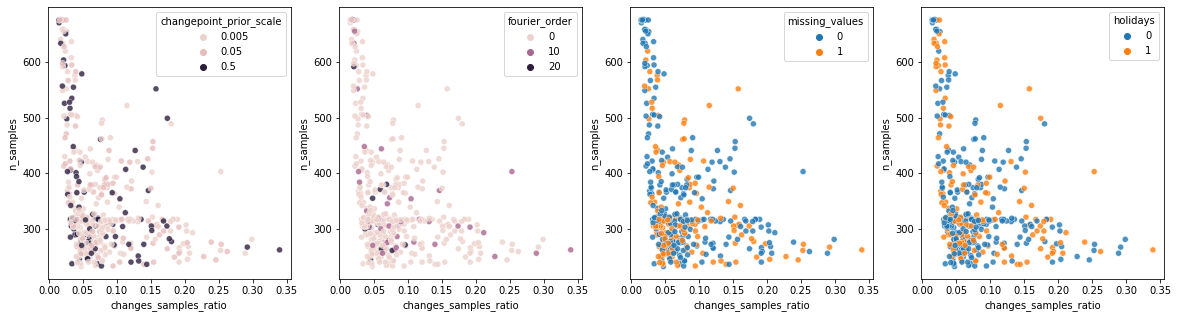

In [ ]:
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order", "missing_values", "holidays"]
set_fig_size((20,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  sns.scatterplot(data = df_best_hyper_parameters, x = "changes_samples_ratio", y = "n_samples", hue = hy_param_name, ax = ax, alpha = 0.8)

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_impactHyperParametersNoLaggedSeriesCountPlot.


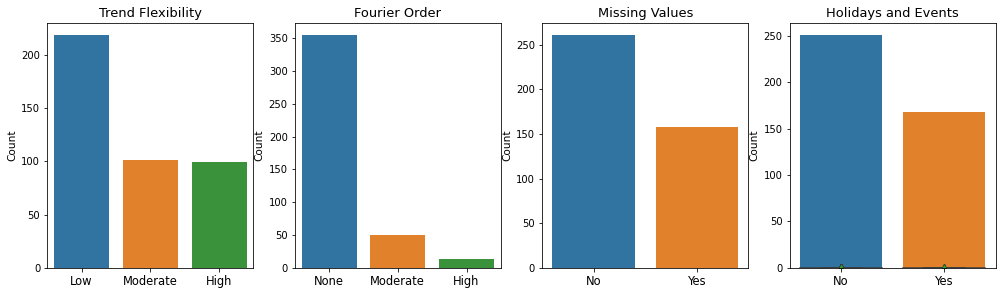

In [ ]:
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order", "missing_values", "holidays"]
plot_titles = ["Trend Flexibility", "Fourier Order", "Missing Values", "Holidays and Events"]
xticks = [["Low", "Moderate", "High"], ["None", "Moderate", "High"], ["No", "Yes"], ["No", "Yes"]]

set_fig_size((17, 4.5))
fontsize = 13
fig, axes = plt.subplots(1, len(hyper_parameters_names))

sns.boxplot(data = df_best_hyper_parameters, x = "changepoint_prior_scale", y = "changes_samples_ratio", showmeans = True)

for hy_param_name, ax, title, xtick in zip(hyper_parameters_names, axes, plot_titles, xticks):

  p = sns.countplot(data = df_best_hyper_parameters, x = hy_param_name, ax = ax)
  p.set_title(title, fontsize = fontsize)
  p.set_xlabel("")
  p.set_ylabel("Count", fontsize = fontsize-2.5)
  p.set_xticklabels(xtick, fontsize = fontsize - 1.5)

# # Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "impactHyperParametersNoLaggedSeriesCountPlot")

(-1.5, 1.5)

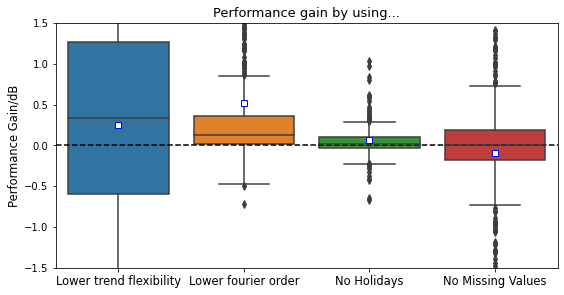

In [ ]:
fontsize = 13

# Boxplot
df_sel = df_all_info.set_index(["product_id", "testing_param_name"]).sort_values(["testing_param_name", "testing_param_value"], ascending = True).groupby(by = ["product_id", "testing_param_name"])["nmse"].diff().dropna().reset_index()

set_fig_size((9,4.5))
p = sns.boxplot(data = df_sel, x = "testing_param_name", y = "nmse", showmeans = True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
p.axhline(0, color = "black", linestyle='--')
p.set_title("Performance gain by using...", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Performance Gain/dB", fontsize = fontsize - 1.5)
p.set_xticklabels(["Lower trend flexibility", "Lower fourier order", "No Holidays", "No Missing Values"], fontsize = fontsize - 1.5)
p.set_ylim(-1.5, 1.5)

# Save fig
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "impactHyperParametersNoLaggedSeriesBoxPlot")

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

In [ ]:
#Missing values has probabily equal to zero, which means it's quite indifferent considering them or not. All the others there is some gain in considering them
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order", "missing_values", "holidays"]
for hyper_parameters_name in hyper_parameters_names:
  data = df_sel[df_sel.testing_param_name == hyper_parameters_name]["nmse"]
  print(hyper_parameters_name)
  print(np.mean(data))
#  print(f_oneway(data, np.zeros(len(data))))
  print(f_oneway(data, np.random.normal(0, 0.5, len(data))))
  

changepoint_prior_scale
0.25646064588608686
F_onewayResult(statistic=8.960508875143784, pvalue=0.0027991913917051726)
fourier_order
0.5171002836219496
F_onewayResult(statistic=31.827006964503756, pvalue=1.9751548289628115e-08)
missing_values
-0.09743936590635592
F_onewayResult(statistic=1.6060984811944734, pvalue=0.2053940043575099)
holidays
0.07186768858411809
F_onewayResult(statistic=1.148219920290371, pvalue=0.2842313337615741)


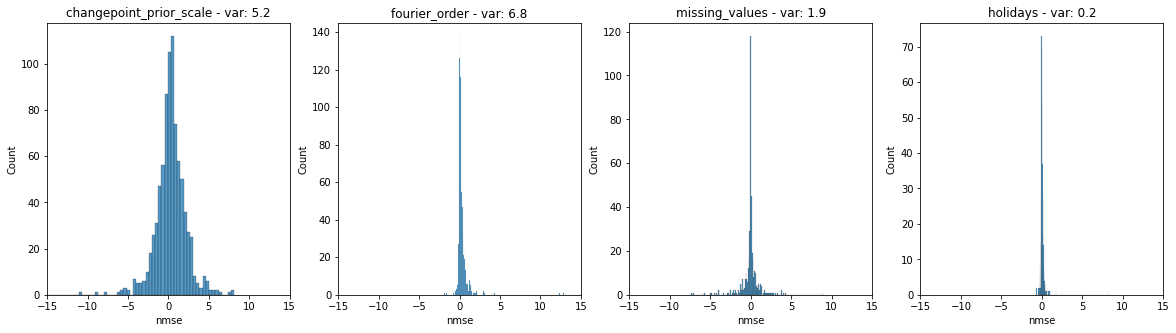

In [ ]:
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order", "missing_values", "holidays"]
set_fig_size((20,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  df_sel = df_all_info[df_all_info["testing_param_name"] == hy_param_name][["product_id", "nmse"]].set_index("product_id")
  df_sel = df_sel.groupby(by = "product_id").diff().dropna()
  p = sns.histplot(data = df_sel.reset_index(), x = "nmse", ax = ax)
  p.set_title(hy_param_name + " - var: " + str(round(np.var(df_sel["nmse"]-np.mean(df_sel["nmse"])), 1)))
  p.set_xlim(-15, 15)

In [ ]:
agora já temos os melhores parâmetros para cada série, será que dá para chegar a conclusões mais gerais?

# changepoint_prior_scale de 0.5 faz overfit claro. Mas é uma boa forma de ver a tendência. Forma robusta de fazer previsões a longo prazo.
# changepoint dos outros está bom - converter todos os hiper parâmetros para isso
# fourier order, sazonalidade já não era esperado que estivesse presente nestas séries em força. Naquelas em que se verifica vamos assumir que foi mais por sorte do que por realmente estar bm.
# holidays dá para ver que têm pouca influência, pois a diferença entre as séries que usam e não é mínima, mas o que é normal porque só têm impacto nalguns dias específicos
# informação relativa aos feriados é muito reduzida porque as séries temporais têm menos de um ano muitas delas e, por isso, não é possível encontrar padrões
# missing values: queríamos ver impacto da previsão com e sem missing values. Há bastante impacto.

Test for particular hyper-parameters

In [ ]:
# Claramente a coisa de Trend + Sazonalidade não se adapta bem às nossas séries temporais, o padrão claramente não encaixa.
# Especialmente sazonalidade
# Mas Trend eventualmente pode ter ajuste mais ou menos razoável, não para previsões a apenas alguns dias mas previsões mais longas no tempo
# Claramente quando a Trend é muito flexível faz de certa forma overfit. Pois é fácil de perceber que se imaginássemos o futuro, a Trend não ia propagar-se bem.
# Por isso, tem-se esperança que esta formulação possa ser boa para fazer previsões a longo prazo, onde a Trend pode ajustar-se melhor
# Vai-se então colocar os parâmetros 

# Sazonality unimportant
df_sel = df_best_hyper_parameters[df_best_hyper_parameters["changepoint_prior_scale"] == 0.005].reset_index().iloc[1]
hyperparameters = df_sel.hyper_parameters
hyperparameters["lagged_series"] = 0

product_id = df_sel.product_id
data = pd.DataFrame(df.loc[product_id]).reset_index()
data["ds"] = data["timestamp"]
country = "PT"

data, m1 = create_prophet_model(data, hyperparameters, country)
m1.fit(data)
forecast1 = m1.predict(data)

# Overfit trend
df_sel = df_best_hyper_parameters[df_best_hyper_parameters["changepoint_prior_scale"] == 0.5].reset_index().iloc[1]
hyperparameters = df_sel.hyper_parameters
hyperparameters
hyperparameters["lagged_series"] = 0

product_id = df_sel.product_id
data = pd.DataFrame(df.loc[product_id]).reset_index()
data["ds"] = data["timestamp"]
country = "PT"

data, m2 = create_prophet_model(data, hyperparameters, country)
m2.fit(data)
forecast2 = m2.predict(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ffn2sqk/p6pfaj3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ffn2sqk/_taqc751.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44402', 'data', 'file=/tmp/tmp0ffn2sqk/p6pfaj3j.json', 'init=/tmp/tmp0ffn2sqk/_taqc751.json', 'output', 'file=/tmp/tmp0ffn2sqk/prophet_modelysydqux2/prophet_model-20221023175244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ff

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_examplesOverfitted.


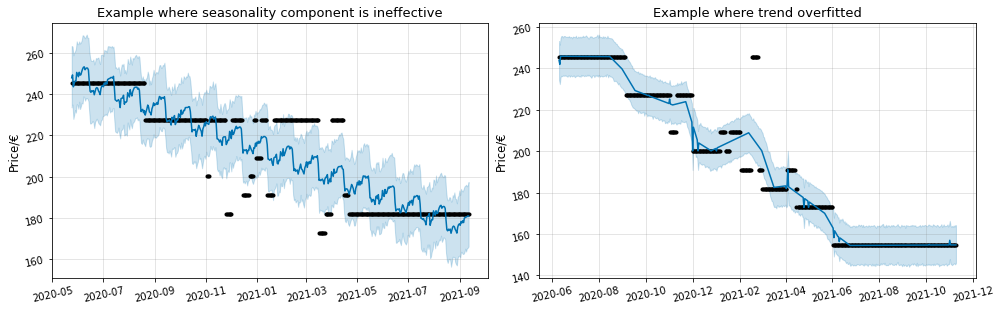

In [ ]:
fontsize = 13
set_fig_size((14, 4.5))
fig, ax = plt.subplots(1, 2)

m1.plot(forecast1, ax = ax[0]);
ax[0].set_title("Example where seasonality component is ineffective", fontsize = fontsize)
ax[0].set_xlabel("")
ax[0].set_ylabel("Price/€", fontsize = fontsize -1.5)
ax[0].tick_params(labelrotation=12)

m2.plot(forecast2, ax = ax[1]);
ax[1].set_title("Example where trend overfitted", fontsize = fontsize)
ax[1].set_xlabel("")
ax[1].set_ylabel("Price/€", fontsize = fontsize - 1.5)
ax[1].tick_params(labelrotation=12)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "examplesOverfitted")

###### Analysis for series with univariate regressors

In [ ]:
# All hyperparameters that were usually read in the next cell were conjoined in a single file - much faster to read this way
#df_all_info_lagged = pd.read_pickle("prophet_all_info_lagged_series")
df_best_hyper_parameters_lagged = pd.read_pickle("prophet_best_hyper_parameters_lagged_series_product_id_lst_0_449")
#df_best_hyper_parameters_lagged["nmse"]  = df_all_info_lagged.groupby(by = "product_id")["nmse"].min()

In [ ]:
# filenames_hyper_parameters_lagged = ["prophet_best_hyper_parameters_lagged_series_product_id_lst_0_49",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_50_99",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_100_149",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_150_199",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_200_249",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_250_299",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_300_349",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_350_399",
#                                      "prophet_best_hyper_parameters_lagged_series_product_id_lst_400_449"]

# filenames_all_info_lagged = ["prophet_all_info_lagged_series_product_id_lst_0_49",
#                              "prophet_all_info_lagged_series_product_id_lst_50_99",
#                              "prophet_all_info_lagged_series_product_id_lst_100_149",
#                              "prophet_all_info_lagged_series_product_id_lst_150_199",
#                              "prophet_all_info_lagged_series_product_id_lst_200_249",
#                              "prophet_all_info_lagged_series_product_id_lst_250_299",
#                              "prophet_all_info_lagged_series_product_id_lst_300_349",
#                              "prophet_all_info_lagged_series_product_id_lst_350_399",
#                              "prophet_all_info_lagged_series_product_id_lst_400_449"]

# #df_best_hyper_parameters_lagged = []
# df_all_info_lagged = []
# for filename_hyper_parameters, filename_all_info in zip(filenames_hyper_parameters_lagged, filenames_all_info_lagged):
#   #df_best_hyper_parameters_lagged.append(pd.read_pickle(filename_hyper_parameters))
#   df_all_info_lagged.append(pd.read_pickle(filename_all_info))

# # df_best_hyper_parameters_lagged = pd.concat(df_best_hyper_parameters_lagged).set_index("product_id")
# # df_best_hyper_parameters_lagged = df_best_hyper_parameters_lagged.rename(columns = {'hyperparameters':'hyper_parameters'})
# # df_best_hyper_parameters_lagged["n_changes"] = n_changes.loc[df_best_hyper_parameters_lagged.index]
# # df_best_hyper_parameters_lagged["n_samples"] = n_samples.loc[df_best_hyper_parameters_lagged.index]
# # df_best_hyper_parameters_lagged["changes_samples_ratio"] = df_best_hyper_parameters_lagged["n_changes"]/df_best_hyper_parameters_lagged["n_samples"]

# df_all_info_lagged = pd.concat(df_all_info_lagged)
# df_best_hyper_parameters_lagged["nmse"]  = df_all_info_lagged.groupby(by = "product_id")["nmse"].min()

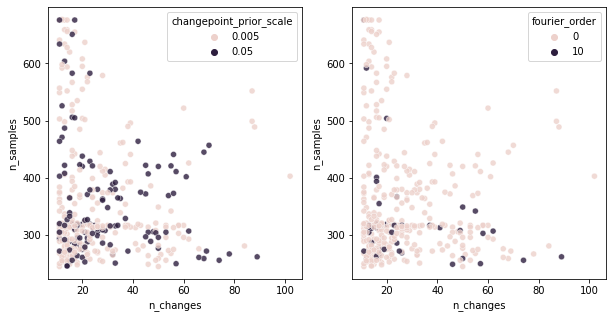

In [ ]:
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order"]
set_fig_size((10,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  sns.scatterplot(data = df_best_hyper_parameters_lagged, x = "n_changes", y = "n_samples", hue = hy_param_name, ax = ax, alpha = 0.8)

Results are similar to the ones presented before. Trend varies quite a lot and generally no sasonality is prefered. It doesn't have that much of an impact but it does.

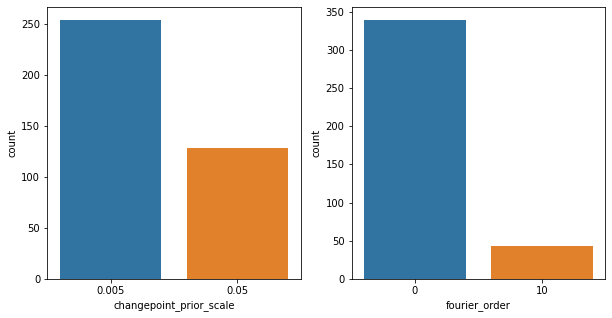

In [ ]:
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order"]
set_fig_size((10,5))
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  sns.countplot(data = df_best_hyper_parameters_lagged, x = hy_param_name, ax = ax)

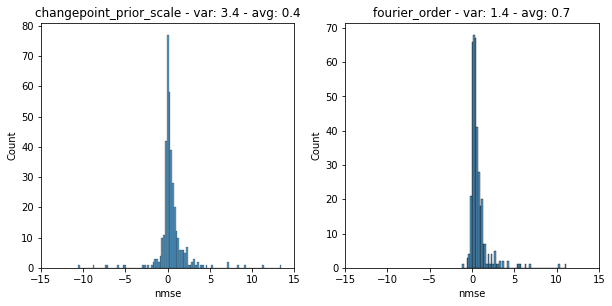

In [ ]:
set_fig_size((10,4.5))
hyper_parameters_names = ["changepoint_prior_scale", "fourier_order"]
fig, axes = plt.subplots(1, len(hyper_parameters_names))
for hy_param_name, ax in zip(hyper_parameters_names, axes):
  df_sel = df_all_info_lagged[df_all_info_lagged["testing_param_name"] == hy_param_name][["product_id", "nmse"]].set_index("product_id")
  df_sel = df_sel.groupby(by = "product_id").diff().dropna()
  p = sns.histplot(data = df_sel.reset_index(), x = "nmse", ax = ax)
  p.set_title(hy_param_name + " - var: " + str(round(np.var(df_sel["nmse"]-np.mean(df_sel["nmse"])), 1)) + " - avg: " + str(round(np.mean(df_sel["nmse"]), 1)))
  p.set_xlim(-15, 15)

In [ ]:
df_best_hyper_parameters["lagged"] = 0
df_best_hyper_parameters_lagged["lagged"] = 1
df_best_hyper_parameters_all = pd.concat([df_best_hyper_parameters, df_best_hyper_parameters_lagged]).drop("lagged_series", axis = 1)
df_best_hyper_parameters_all_flt = df_best_hyper_parameters_all.groupby("product_id").apply(lambda x : x[x["nmse"] == x["nmse"].min()])        # Best hyper-parameters between lagged series and not lagged series. What it is verified is that lagged series always conduct to best_hyper_parameters

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_performanceGainLagged.


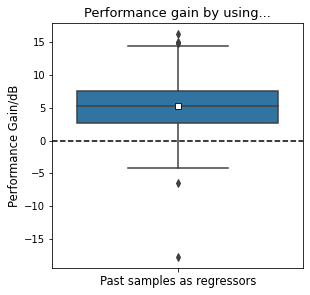

In [ ]:
fontsize = 13

# Boxplot
df_sel = df_best_hyper_parameters_all.reset_index().set_index(["product_id", "lagged"]).sort_values("lagged", ascending = True).groupby(by = ["product_id"])["nmse"].diff().dropna().reset_index()

set_fig_size((4.5,4.5))
p = sns.boxplot(data = -df_sel["nmse"], showmeans = True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
p.axhline(0, color = "black", linestyle='--')
p.set_title("Performance gain by using...", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Performance Gain/dB", fontsize = fontsize - 1.5)
p.set_xticklabels(["Past samples as regressors"], fontsize = fontsize - 1.5)
#p.set_ylim(-1.5, 1.5)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "performanceGainLagged")

##### Get predictions

In [ ]:
def update_hyper_parameters(hyperparameters):
  hyperparameters["changepoint_prior_scale"] = min(hyperparameters["changepoint_prior_scale"], 0.05)    # so the trend doens't overfit
  hyperparameters["missing_values"] = 0                                                                 # so it can be compared with ARIMA model
  return hyperparameters

# Atualizar df dos hiper_parametros
df_best_hyper_parameters["updated"] = df_best_hyper_parameters["hyper_parameters"].apply(update_hyper_parameters)   
#df_best_hyper_parameters_lagged["updated"] = df_best_hyper_parameters_lagged["hyper_parameters"].apply(update_hyper_parameters)   

###### Predictions for series without univariate regressors

In [ ]:
# Initializations
all_prophet_info = []                       # store all info of each hyper-parameter for each timeseries
init_count = 350
end_count = 399
count = init_count-1

for product_id in product_id_lst[init_count:end_count+1]:

  count = count + 1
  if count == end_count+1:
    break

  print(count)

  # Get data
  data = pd.DataFrame(df.loc[product_id]).reset_index()
  data["ds"] = data["timestamp"]

  # Product characteristics
  base_info = {"product_id": product_id,
               "country": data.country.unique()[0],
               "product": data["product"].unique()[0],
               "company": data.company.unique()[0],
               "product_group_id": data.product_group_id.unique()[0],
               "company_id": data.company_id.unique()[0],
               "offer_type": data.offer_type.unique()[0]}

  # Initializations
  hyper_parameters = df_best_hyper_parameters["updated"].loc[product_id]
  hyper_parameters["lagged_series"] = 0

  # Create prophet model
  data, m = create_prophet_model(data, hyper_parameters, base_info["country"], )

  # Cross-validation
  m.fit(data[["ds", "y"]])
  forecast = m.predict(data)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  df_cv = cross_validation(m, initial = '122 days', period= '5 days', horizon = '60 days', parallel = "dask")      # 4 months of initial

  # Metrics
  df_p = performance_metrics(df_cv)
  nmse = get_nmse(df_cv["y"], df_cv["yhat"])

  # Saving results
  new_info = {"data" : data[["ds", "y"]],
              "forecast": forecast,
              "hyper_parameters": hyper_parameters,
              "cross_validation_results": df_cv,
              "performance_metrics" : df_p,
              "nmse": nmse}

  info = base_info.copy()
  info.update(new_info)
  all_prophet_info.append(info)
  
df_all_prophet_info = pd.DataFrame(all_prophet_info)
df_all_prophet_info.to_pickle("prophet_predictions_univariate_no_lagged_all_prophet_info_" + str(init_count) + "_" + str(end_count))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/axwqz9dh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/oexo_f77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73726', 'data', 'file=/tmp/tmpdz0lh6nw/axwqz9dh.json', 'init=/tmp/tmpdz0lh6nw/oexo_f77.json', 'output', 'file=/tmp/tmp2xixs0y6/prophet_model-20220927154621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


350


15:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 73 forecasts with cutoffs between 2020-09-10 00:00:00 and 2021-09-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/3riv1_7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/trdul8gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56930', 'data', 'file=/tmp/tmpdz0lh6nw/3riv1_7w.json', 'init=/tmp/tmpdz0lh6nw/trdul8gv.json', 'output', 'file=/tmp/tmpmvvp4vm7/prophet_model-20220927154816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:16 - cmdstanpy - INFO - Chain [1] start process

351


INFO:prophet:Making 66 forecasts with cutoffs between 2020-07-05 00:00:00 and 2021-05-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/0abjsf97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/5ol7twjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73433', 'data', 'file=/tmp/tmpdz0lh6nw/0abjsf97.json', 'init=/tmp/tmpdz0lh6nw/5ol7twjl.json', 'output', 'file=/tmp/tmpsiw6fz9i/prophet_model-20220927154942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done proces

352


INFO:prophet:Making 37 forecasts with cutoffs between 2020-09-09 00:00:00 and 2021-03-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/6jzmhres.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/zhp3kt2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44253', 'data', 'file=/tmp/tmpdz0lh6nw/6jzmhres.json', 'init=/tmp/tmpdz0lh6nw/zhp3kt2m.json', 'output', 'file=/tmp/tmpjjcqey3s/prophet_model-20220927155031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1] done proces

353


INFO:prophet:Making 30 forecasts with cutoffs between 2020-09-01 00:00:00 and 2021-01-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/cghc87h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/z3dzv7a3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36555', 'data', 'file=/tmp/tmpdz0lh6nw/cghc87h2.json', 'init=/tmp/tmpdz0lh6nw/z3dzv7a3.json', 'output', 'file=/tmp/tmp9ch10x0l/prophet_model-20220927155114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


354


15:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 99 forecasts with cutoffs between 2020-05-08 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/oxxqsbnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/_sssfcay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21110', 'data', 'file=/tmp/tmpdz0lh6nw/oxxqsbnd.json', 'init=/tmp/tmpdz0lh6nw/_sssfcay.json', 'output', 'file=/tmp/tmpk00i96kl/prophet_model-20220927155328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:28 - cmdstanpy - INFO - Chain [1] start process

355


INFO:prophet:Making 22 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-04-22 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/5w6muk54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/3ys6jhl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18206', 'data', 'file=/tmp/tmpdz0lh6nw/5w6muk54.json', 'init=/tmp/tmpdz0lh6nw/3ys6jhl9.json', 'output', 'file=/tmp/tmpgwzv546o/prophet_model-20220927155400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


356


15:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 99 forecasts with cutoffs between 2020-05-08 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/2og97wlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/_g5xg_bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66751', 'data', 'file=/tmp/tmpdz0lh6nw/2og97wlr.json', 'init=/tmp/tmpdz0lh6nw/_g5xg_bs.json', 'output', 'file=/tmp/tmp98ztju6l/prophet_model-20220927155618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:18 - cmdstanpy - INFO - Chain [1] start process

357


INFO:prophet:Making 28 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/o2oai_m1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/ceyjexhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26187', 'data', 'file=/tmp/tmpdz0lh6nw/o2oai_m1.json', 'init=/tmp/tmpdz0lh6nw/ceyjexhi.json', 'output', 'file=/tmp/tmpjjl5r41g/prophet_model-20220927155657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:57 - cmdstanpy - INFO - Chain [1] done proces

358


INFO:prophet:Making 27 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/17kv4c64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/_1ejkn2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62272', 'data', 'file=/tmp/tmpdz0lh6nw/17kv4c64.json', 'init=/tmp/tmpdz0lh6nw/_1ejkn2c.json', 'output', 'file=/tmp/tmpxisw3x25/prophet_model-20220927155734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done proces

359


INFO:prophet:Making 95 forecasts with cutoffs between 2020-05-28 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/n4hhd9zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/1b47jt9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84533', 'data', 'file=/tmp/tmpdz0lh6nw/n4hhd9zi.json', 'init=/tmp/tmpdz0lh6nw/1b47jt9q.json', 'output', 'file=/tmp/tmp77x7523f/prophet_model-20220927155935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done proces

360


INFO:prophet:Making 48 forecasts with cutoffs between 2021-01-17 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/98a7p3m5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/nkk3fnox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21272', 'data', 'file=/tmp/tmpdz0lh6nw/98a7p3m5.json', 'init=/tmp/tmpdz0lh6nw/nkk3fnox.json', 'output', 'file=/tmp/tmpioryef7v/prophet_model-20220927160040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:40 - cmdstanpy - INFO - Chain [1] done proces

361


INFO:prophet:Making 95 forecasts with cutoffs between 2020-05-28 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/1oc1xh6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/t6e8mjlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26540', 'data', 'file=/tmp/tmpdz0lh6nw/1oc1xh6f.json', 'init=/tmp/tmpdz0lh6nw/t6e8mjlr.json', 'output', 'file=/tmp/tmper3u625c/prophet_model-20220927160244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:02:44 - cmdstanpy - INFO - Chain [1] done proces

362


INFO:prophet:Making 38 forecasts with cutoffs between 2021-03-09 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/84x2hev5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/x8vszlpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14201', 'data', 'file=/tmp/tmpdz0lh6nw/84x2hev5.json', 'init=/tmp/tmpdz0lh6nw/x8vszlpi.json', 'output', 'file=/tmp/tmp3c0e2tzq/prophet_model-20220927160334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done proces

363


INFO:prophet:Making 65 forecasts with cutoffs between 2020-09-08 00:00:00 and 2021-07-25 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/ae0msn9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/w2p7tohn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64073', 'data', 'file=/tmp/tmpdz0lh6nw/ae0msn9v.json', 'init=/tmp/tmpdz0lh6nw/w2p7tohn.json', 'output', 'file=/tmp/tmpm6je0tc2/prophet_model-20220927160459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:04:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:59 - cmdstanpy - INFO - Chain [1] done proces

364


INFO:prophet:Making 38 forecasts with cutoffs between 2021-01-20 00:00:00 and 2021-07-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/soayxsn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/dwkhmy_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9168', 'data', 'file=/tmp/tmpdz0lh6nw/soayxsn3.json', 'init=/tmp/tmpdz0lh6nw/dwkhmy_3.json', 'output', 'file=/tmp/tmpeppnu2k4/prophet_model-20220927160551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:51 - cmdstanpy - INFO - Chain [1] done process

365


INFO:prophet:Making 64 forecasts with cutoffs between 2020-08-30 00:00:00 and 2021-07-11 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/vls7x0y_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/rl3mkgw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37139', 'data', 'file=/tmp/tmpdz0lh6nw/vls7x0y_.json', 'init=/tmp/tmpdz0lh6nw/rl3mkgw6.json', 'output', 'file=/tmp/tmpbp0rtu6r/prophet_model-20220927160716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:07:16 - cmdstanpy - INFO - Chain [1] done proces

366


INFO:prophet:Making 36 forecasts with cutoffs between 2020-12-28 00:00:00 and 2021-06-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/horlente.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/ay7nqwbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58268', 'data', 'file=/tmp/tmpdz0lh6nw/horlente.json', 'init=/tmp/tmpdz0lh6nw/ay7nqwbp.json', 'output', 'file=/tmp/tmp7duse9xw/prophet_model-20220927160807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:08:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


367


16:08:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2020-08-04 00:00:00 and 2021-02-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/pspelk6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/6lc69ir1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64137', 'data', 'file=/tmp/tmpdz0lh6nw/pspelk6r.json', 'init=/tmp/tmpdz0lh6nw/6lc69ir1.json', 'output', 'file=/tmp/tmpzomwroad/prophet_model-20220927160900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:09:00 - cmdstanpy - INFO - Chain [1] start process

368


16:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 99 forecasts with cutoffs between 2020-05-08 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/mz5mfro2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/se8vy8mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87675', 'data', 'file=/tmp/tmpdz0lh6nw/mz5mfro2.json', 'init=/tmp/tmpdz0lh6nw/se8vy8mw.json', 'output', 'file=/tmp/tmp4xffk06y/prophet_model-20220927161110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:10 - cmdstanpy - INFO - Chain [1] start process

369


16:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 90 forecasts with cutoffs between 2020-06-22 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/_b5cxo__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/n2f5ygl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77531', 'data', 'file=/tmp/tmpdz0lh6nw/_b5cxo__.json', 'init=/tmp/tmpdz0lh6nw/n2f5ygl_.json', 'output', 'file=/tmp/tmpa2syb5kc/prophet_model-20220927161312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:13:12 - cmdstanpy - INFO - Chain [1] start process

370


INFO:prophet:Making 57 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/ze36awnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/g2sxxeug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72107', 'data', 'file=/tmp/tmpdz0lh6nw/ze36awnn.json', 'init=/tmp/tmpdz0lh6nw/g2sxxeug.json', 'output', 'file=/tmp/tmp75rwis5w/prophet_model-20220927161426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


371


16:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 80 forecasts with cutoffs between 2020-08-11 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/bzk_fgy2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/dm8vgpz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39945', 'data', 'file=/tmp/tmpdz0lh6nw/bzk_fgy2.json', 'init=/tmp/tmpdz0lh6nw/dm8vgpz6.json', 'output', 'file=/tmp/tmpaa9fs0rv/prophet_model-20220927161614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:14 - cmdstanpy - INFO - Chain [1] start process

372


INFO:prophet:Making 53 forecasts with cutoffs between 2020-12-03 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/4hvewp8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/6eyqtw2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43633', 'data', 'file=/tmp/tmpdz0lh6nw/4hvewp8q.json', 'init=/tmp/tmpdz0lh6nw/6eyqtw2n.json', 'output', 'file=/tmp/tmpn3wqio00/prophet_model-20220927161725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done proces

373


INFO:prophet:Making 63 forecasts with cutoffs between 2020-10-08 00:00:00 and 2021-08-14 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/h38n74w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/d1bq1ej2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79203', 'data', 'file=/tmp/tmpdz0lh6nw/h38n74w1.json', 'init=/tmp/tmpdz0lh6nw/d1bq1ej2.json', 'output', 'file=/tmp/tmpfmp6rkb5/prophet_model-20220927161849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done proces

374


INFO:prophet:Making 63 forecasts with cutoffs between 2020-08-29 00:00:00 and 2021-07-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/x_55xi1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/lmrlwzkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47008', 'data', 'file=/tmp/tmpdz0lh6nw/x_55xi1f.json', 'init=/tmp/tmpdz0lh6nw/lmrlwzkp.json', 'output', 'file=/tmp/tmp3_s5jcgq/prophet_model-20220927162014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done proces

375


INFO:prophet:Making 34 forecasts with cutoffs between 2020-08-12 00:00:00 and 2021-01-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/49zrlzud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/5wm9h7bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83126', 'data', 'file=/tmp/tmpdz0lh6nw/49zrlzud.json', 'init=/tmp/tmpdz0lh6nw/5wm9h7bv.json', 'output', 'file=/tmp/tmpeimg243z/prophet_model-20220927162100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:00 - cmdstanpy - INFO - Chain [1] done proces

376


INFO:prophet:Making 63 forecasts with cutoffs between 2020-11-04 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/vpy1o6mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/9hb1hti6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71150', 'data', 'file=/tmp/tmpdz0lh6nw/vpy1o6mu.json', 'init=/tmp/tmpdz0lh6nw/9hb1hti6.json', 'output', 'file=/tmp/tmp1np556o6/prophet_model-20220927162222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done proces

377


INFO:prophet:Making 57 forecasts with cutoffs between 2020-12-04 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/r0bwc5vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/hkxetbdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56917', 'data', 'file=/tmp/tmpdz0lh6nw/r0bwc5vu.json', 'init=/tmp/tmpdz0lh6nw/hkxetbdf.json', 'output', 'file=/tmp/tmpm6waw7r3/prophet_model-20220927162334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done proces

378


INFO:prophet:Making 48 forecasts with cutoffs between 2021-01-17 00:00:00 and 2021-09-09 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/xw12b33b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/y7m8b2sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59447', 'data', 'file=/tmp/tmpdz0lh6nw/xw12b33b.json', 'init=/tmp/tmpdz0lh6nw/y7m8b2sw.json', 'output', 'file=/tmp/tmpfelq5axh/prophet_model-20220927162440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


379


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 2020-11-12 00:00:00 and 2021-08-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/x6i2y7na.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/utih532h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9606', 'data', 'file=/tmp/tmpdz0lh6nw/x6i2y7na.json', 'init=/tmp/tmpdz0lh6nw/utih532h.json', 'output', 'file=/tmp/tmp0_zb5q7i/prophet_model-20220927162602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:02 - cmdstanpy - INFO - Chain [1] start processi

380


INFO:prophet:Making 47 forecasts with cutoffs between 2020-12-05 00:00:00 and 2021-07-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/ah5wut07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdz0lh6nw/3jrpqgf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27997', 'data', 'file=/tmp/tmpdz0lh6nw/ah5wut07.json', 'init=/tmp/tmpdz0lh6nw/3jrpqgf3.json', 'output', 'file=/tmp/tmpmhly8bzx/prophet_model-20220927162703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done proces

381


INFO:prophet:Making 51 forecasts with cutoffs between 2020-11-05 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:37231' processes=2 threads=2, memory=12.68 GiB>


###### Predictions for series with univariate regressors

In [ ]:
### Prediction with for loop

# Features
prediction_horizon = 7
lag_interval = 14
min_lag = prediction_horizon
max_lag = (min_lag - 1) + lag_interval

init_count_list = list(range(150, 351, 50))
end_count_list =  list(range(199, 400, 50))

for init_count, end_count in zip(init_count_list, end_count_list):

  # Initializations
  all_info = []                       # store all info of each hyper-paramter for each timeseries
  count = init_count-1

  df_horizon = df_all.copy()
  df_horizon = get_features_df_product_group_id(df_horizon, feature_types = ["price_euro"], max_lag = max_lag, min_lag = min_lag)
  regressors_horizon = generate_regressors(feature_types = ["price_euro"], max_lag = max_lag, min_lag = min_lag)

  for product_id in product_id_lst[init_count:end_count+1]:

    count = count + 1
    print(count)

    # Get data
    data = pd.DataFrame(df_horizon.loc[product_id]).reset_index()
    data["ds"] = data["timestamp"]

    # Product characteristics
    base_info = {"product_id": product_id,
                "country": data.country.unique()[0],
                "product": data["product"].unique()[0],
                "company": data.company.unique()[0],
                "product_group_id": data.product_group_id.unique()[0],
                "company_id": data.company_id.unique()[0],
                "offer_type": data.offer_type.unique()[0]}

    # Initializations
    values = df_best_hyper_parameters_lagged["updated"].loc[product_id]  
    values["lagged_series"] = 1 

    # Create prophet model
    data, m = create_prophet_model(data, values, base_info["country"], regressors_horizon)

    # Cross-validation
    m.fit(data)
    forecast = m.predict(data)

    initial = 122
    period = 5
    horizon = 5
    df_cv = cross_validation(m, initial = str(initial) + ' days', period = str(period) + ' days', horizon = str(horizon) + ' days', parallel = "dask")      # 4 months of initial

    # Metrics
    df_p = performance_metrics(df_cv)
    nmse = get_nmse(df_cv["y"], df_cv["yhat"])

    # Saving results
    new_info = {"data" : data[["ds", "y"]],
                "forecast"  : forecast,
                "hyper_parameters": values.copy(),
                "cross_validation_results": df_cv,
                "performance_metrics" : df_p,
                "cross_validation_initial": initial,
                "cross_validation_period": period,
                "cross_validation_horizon": horizon,
                "nmse": nmse,
                "prediction_horizon": prediction_horizon,
                "min_lag": min_lag,
                "max_lag": max_lag}

    info = base_info.copy()
    info.update(new_info)
    all_info.append(info)

  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("prophet_predictions_univariate_lagged_all_prophet_info_prediction_horizon_" + str(prediction_horizon) + "_" + str(init_count) + "_" + str(end_count))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


150


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yq2w5_3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/d194jjzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19519', 'data', 'file=/tmp/tmpb9vjzdlw/yq2w5_3c.json', 'init=/tmp/tmpb9vjzdlw/d194jjzq.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_6gep497/prophet_model-20221006165945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Clien

151


17:00:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-07 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hj8zds_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2phy6r63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35251', 'data', 'file=/tmp/tmpb9vjzdlw/hj8zds_v.json', 'init=/tmp/tmpb9vjzdlw/2phy6r63.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwe8sv7ch/prophet_model-20221006170038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:38 - cmdstanpy - INFO - C

152


INFO:prophet:Making 31 forecasts with cutoffs between 2021-06-07 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3iu_4p1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lf_xwtbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58988', 'data', 'file=/tmp/tmpb9vjzdlw/3iu_4p1r.json', 'init=/tmp/tmpb9vjzdlw/lf_xwtbn.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelqo38m3zy/prophet_model-20221006170057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:57 - cmdstanpy - INFO -

153


INFO:prophet:Making 28 forecasts with cutoffs between 2021-06-22 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4kqa77tz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pp3571pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52611', 'data', 'file=/tmp/tmpb9vjzdlw/4kqa77tz.json', 'init=/tmp/tmpb9vjzdlw/pp3571pp.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model8fzb6x3v/prophet_model-20221006170114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:14 - cmdstanpy - INFO -

154


INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kplewmyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0vjfeawu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85401', 'data', 'file=/tmp/tmpb9vjzdlw/kplewmyq.json', 'init=/tmp/tmpb9vjzdlw/0vjfeawu.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeldl84aysp/prophet_model-20221006170134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:34 - cmdstanpy - INFO -

155


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3v9qg7sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gufqo54p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88426', 'data', 'file=/tmp/tmpb9vjzdlw/3v9qg7sj.json', 'init=/tmp/tmpb9vjzdlw/gufqo54p.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelpz8muwef/prophet_model-20221006170156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:56 - cmdstanpy - INFO -

156


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lx8s1w9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7o30m9gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93708', 'data', 'file=/tmp/tmpb9vjzdlw/lx8s1w9e.json', 'init=/tmp/tmpb9vjzdlw/7o30m9gw.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcroju1ce/prophet_model-20221006170214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:14 - cmdstanpy - INFO -

157


INFO:prophet:Making 32 forecasts with cutoffs between 2021-06-01 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/c665ojdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/osmzv8s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79177', 'data', 'file=/tmp/tmpb9vjzdlw/c665ojdq.json', 'init=/tmp/tmpb9vjzdlw/osmzv8s4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelzex970tn/prophet_model-20221006170233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:34 - cmdstanpy - INFO -

158


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1k1x326y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xayhcqus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6590', 'data', 'file=/tmp/tmpb9vjzdlw/1k1x326y.json', 'init=/tmp/tmpb9vjzdlw/xayhcqus.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model21xqanf3/prophet_model-20221006170255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:55 - cmdstanpy - INFO - 

159


INFO:prophet:Making 27 forecasts with cutoffs between 2020-11-01 00:00:00 and 2021-03-11 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


160


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/017vcko0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7bz3nngo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25134', 'data', 'file=/tmp/tmpb9vjzdlw/017vcko0.json', 'init=/tmp/tmpb9vjzdlw/7bz3nngo.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7egubs5n/prophet_model-20221006170314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

161


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


162


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hoqusmiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hzldqhlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98849', 'data', 'file=/tmp/tmpb9vjzdlw/hoqusmiz.json', 'init=/tmp/tmpb9vjzdlw/hzldqhlb.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model317hzu4z/prophet_model-20221006170401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

163


INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-10 00:00:00 and 2021-10-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nw1hpz7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hniiriow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12179', 'data', 'file=/tmp/tmpb9vjzdlw/nw1hpz7d.json', 'init=/tmp/tmpb9vjzdlw/hniiriow.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrk112dme/prophet_model-20221006170445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


164


17:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 94 forecasts with cutoffs between 2020-07-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vtwsdm5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cc860tsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6025', 'data', 'file=/tmp/tmpb9vjzdlw/vtwsdm5v.json', 'init=/tmp/tmpb9vjzdlw/cc860tsp.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3o9dp4ex/prophet_model-20221006170548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:48 - cmdstanpy - INFO - Ch

165


INFO:prophet:Making 73 forecasts with cutoffs between 2020-07-12 00:00:00 and 2021-07-07 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/s_v2jocq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vqwqcw_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29688', 'data', 'file=/tmp/tmpb9vjzdlw/s_v2jocq.json', 'init=/tmp/tmpb9vjzdlw/vqwqcw_x.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model6243dl73/prophet_model-20221006170634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


166


17:06:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kokyfsgq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hadah5nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96508', 'data', 'file=/tmp/tmpb9vjzdlw/kokyfsgq.json', 'init=/tmp/tmpb9vjzdlw/hadah5nh.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeljst9fdzj/prophet_model-20221006170657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:57 - cmdstanpy - INFO - C

167


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_hiemupo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xhfua4hw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72357', 'data', 'file=/tmp/tmpb9vjzdlw/_hiemupo.json', 'init=/tmp/tmpb9vjzdlw/xhfua4hw.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelj1s8dd6z/prophet_model-20221006170719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:20 - cmdstanpy - INFO -

168


INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_z4zergu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5wlumwa5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20018', 'data', 'file=/tmp/tmpb9vjzdlw/_z4zergu.json', 'init=/tmp/tmpb9vjzdlw/5wlumwa5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelfel05bgb/prophet_model-20221006170742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:42 - cmdstanpy - INFO -

169


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


170


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lckeb_ju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/m_lnlndh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18074', 'data', 'file=/tmp/tmpb9vjzdlw/lckeb_ju.json', 'init=/tmp/tmpb9vjzdlw/m_lnlndh.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelw3f7kj74/prophet_model-20221006170805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily sea

171


17:08:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hhp1yq4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nq0aonep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88465', 'data', 'file=/tmp/tmpb9vjzdlw/hhp1yq4g.json', 'init=/tmp/tmpb9vjzdlw/nq0aonep.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcb1i_0tn/prophet_model-20221006170853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:53 - cmdstanpy - INFO - C

172


INFO:prophet:Making 51 forecasts with cutoffs between 2021-02-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4v4a5oxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vphx45m5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47153', 'data', 'file=/tmp/tmpb9vjzdlw/4v4a5oxz.json', 'init=/tmp/tmpb9vjzdlw/vphx45m5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model5ixwf_o7/prophet_model-20221006170923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:23 - cmdstanpy - INFO -

173


INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/k4jmu8ra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hmmln6v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21439', 'data', 'file=/tmp/tmpb9vjzdlw/k4jmu8ra.json', 'init=/tmp/tmpb9vjzdlw/hmmln6v0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeljs76ea5t/prophet_model-20221006171000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:00 - cmdstanpy - INFO -

174


INFO:prophet:Making 32 forecasts with cutoffs between 2021-02-06 00:00:00 and 2021-07-11 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7ftlnyoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2ki4wuwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5129', 'data', 'file=/tmp/tmpb9vjzdlw/7ftlnyoy.json', 'init=/tmp/tmpb9vjzdlw/2ki4wuwo.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbwvv43pz/prophet_model-20221006171023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:23 - cmdstanpy - INFO - 

175


INFO:prophet:Making 42 forecasts with cutoffs between 2020-12-11 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l_a79wsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1fkcaxjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83337', 'data', 'file=/tmp/tmpb9vjzdlw/l_a79wsx.json', 'init=/tmp/tmpb9vjzdlw/1fkcaxjl.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelo96epf3_/prophet_model-20221006171048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:48 - cmdstanpy - INFO -

176


INFO:prophet:Making 41 forecasts with cutoffs between 2020-12-02 00:00:00 and 2021-06-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7hgtqald.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ljz70tcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2363', 'data', 'file=/tmp/tmpb9vjzdlw/7hgtqald.json', 'init=/tmp/tmpb9vjzdlw/ljz70tcp.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeld2i86cg7/prophet_model-20221006171113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


177


17:11:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/y1965qmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ux77o6q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90222', 'data', 'file=/tmp/tmpb9vjzdlw/y1965qmk.json', 'init=/tmp/tmpb9vjzdlw/ux77o6q_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelvor9be5r/prophet_model-20221006171136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:36 - cmdstanpy - INFO - C

178


17:11:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2kwp_maa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kxougu_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20263', 'data', 'file=/tmp/tmpb9vjzdlw/2kwp_maa.json', 'init=/tmp/tmpb9vjzdlw/kxougu_6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeld3x9ofid/prophet_model-20221006171159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:59 - cmdstanpy - INFO - C

179


17:11:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_3_x2c2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ay2ykik1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57988', 'data', 'file=/tmp/tmpb9vjzdlw/_3_x2c2g.json', 'init=/tmp/tmpb9vjzdlw/ay2ykik1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model0e6yih1u/prophet_model-20221006171223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:23 - cmdstanpy - INFO - C

180


17:12:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-12 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pq82rleb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/e3umcgol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81632', 'data', 'file=/tmp/tmpb9vjzdlw/pq82rleb.json', 'init=/tmp/tmpb9vjzdlw/e3umcgol.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_zsznrlv/prophet_model-20221006171248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:48 - cmdstanpy - INFO - C

181


17:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0r0219um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tsw8taro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58991', 'data', 'file=/tmp/tmpb9vjzdlw/0r0219um.json', 'init=/tmp/tmpb9vjzdlw/tsw8taro.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelhmscn1e7/prophet_model-20221006171311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:11 - cmdstanpy - INFO - C

182


INFO:prophet:Making 27 forecasts with cutoffs between 2021-06-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/eqm3ocwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/agpavpaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2655', 'data', 'file=/tmp/tmpb9vjzdlw/eqm3ocwf.json', 'init=/tmp/tmpb9vjzdlw/agpavpaf.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelpiml4a8z/prophet_model-20221006171328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:28 - cmdstanpy - INFO - 

183


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/sx56gh39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6hb1002g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18893', 'data', 'file=/tmp/tmpb9vjzdlw/sx56gh39.json', 'init=/tmp/tmpb9vjzdlw/6hb1002g.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelmzg4oe3d/prophet_model-20221006171346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:46 - cmdstanpy - INFO -

184


INFO:prophet:Making 28 forecasts with cutoffs between 2021-06-22 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lcimhtxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xjwhbsqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=789', 'data', 'file=/tmp/tmpb9vjzdlw/lcimhtxa.json', 'init=/tmp/tmpb9vjzdlw/xjwhbsqk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrgfs5hi8/prophet_model-20221006171404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:04 - cmdstanpy - INFO - C

185


INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ibpk_98q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/x95md728.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35314', 'data', 'file=/tmp/tmpb9vjzdlw/ibpk_98q.json', 'init=/tmp/tmpb9vjzdlw/x95md728.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwbs9gx26/prophet_model-20221006171424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:24 - cmdstanpy - INFO -

186


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/t95ow_l1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l5mbflq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2169', 'data', 'file=/tmp/tmpb9vjzdlw/t95ow_l1.json', 'init=/tmp/tmpb9vjzdlw/l5mbflq0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelzfhr_f9f/prophet_model-20221006171446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:46 - cmdstanpy - INFO - 

187


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/dnsla3jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/la429p_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61592', 'data', 'file=/tmp/tmpb9vjzdlw/dnsla3jd.json', 'init=/tmp/tmpb9vjzdlw/la429p_e.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model0ci2oigw/prophet_model-20221006171504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:04 - cmdstanpy - INFO -

188


INFO:prophet:Making 32 forecasts with cutoffs between 2021-06-01 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0rxmlfyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/c4y6x5uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32131', 'data', 'file=/tmp/tmpb9vjzdlw/0rxmlfyz.json', 'init=/tmp/tmpb9vjzdlw/c4y6x5uy.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model67c9nqyi/prophet_model-20221006171524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


189


17:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/fhhfc470.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/q8u20chd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34585', 'data', 'file=/tmp/tmpb9vjzdlw/fhhfc470.json', 'init=/tmp/tmpb9vjzdlw/q8u20chd.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model5ljm0yqn/prophet_model-20221006171547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:47 - cmdstanpy - INFO - C

190


INFO:prophet:Making 32 forecasts with cutoffs between 2021-06-02 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5ju7b_gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/flacl8z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54197', 'data', 'file=/tmp/tmpb9vjzdlw/5ju7b_gj.json', 'init=/tmp/tmpb9vjzdlw/flacl8z3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_l_k4t6y/prophet_model-20221006171610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:10 - cmdstanpy - INFO -

191


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/klxp4g61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rhjfh2i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46913', 'data', 'file=/tmp/tmpb9vjzdlw/klxp4g61.json', 'init=/tmp/tmpb9vjzdlw/rhjfh2i4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model0asqwnoj/prophet_model-20221006171632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:32 - cmdstanpy - INFO -

192


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l6_x8tz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/as65gpjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74876', 'data', 'file=/tmp/tmpb9vjzdlw/l6_x8tz8.json', 'init=/tmp/tmpb9vjzdlw/as65gpjk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbibdypg2/prophet_model-20221006171651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:51 - cmdstanpy - INFO -

193


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/goxr5tn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/v9e91w0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4339', 'data', 'file=/tmp/tmpb9vjzdlw/goxr5tn2.json', 'init=/tmp/tmpb9vjzdlw/v9e91w0j.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4svafuqt/prophet_model-20221006171715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:15 - cmdstanpy - INFO - 

194


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/efplbkmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2d00_i_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46572', 'data', 'file=/tmp/tmpb9vjzdlw/efplbkmu.json', 'init=/tmp/tmpb9vjzdlw/2d00_i_k.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelfo9prl8o/prophet_model-20221006171738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


195


17:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-23 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_wcemo9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/e0xexde8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3810', 'data', 'file=/tmp/tmpb9vjzdlw/_wcemo9h.json', 'init=/tmp/tmpb9vjzdlw/e0xexde8.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model44t7xsgl/prophet_model-20221006171814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:14 - cmdstanpy - INFO - Ch

196


INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rvc8kpao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/bysd8j8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96039', 'data', 'file=/tmp/tmpb9vjzdlw/rvc8kpao.json', 'init=/tmp/tmpb9vjzdlw/bysd8j8t.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbicqg4m2/prophet_model-20221006171855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


197


17:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 64 forecasts with cutoffs between 2020-12-24 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ij0_h3za.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/iojrr7p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70392', 'data', 'file=/tmp/tmpb9vjzdlw/ij0_h3za.json', 'init=/tmp/tmpb9vjzdlw/iojrr7p6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelnjoszfd7/prophet_model-20221006171937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:37 - cmdstanpy - INFO - C

198


INFO:prophet:Making 25 forecasts with cutoffs between 2021-07-07 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ols9x4x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4ez6a722.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87', 'data', 'file=/tmp/tmpb9vjzdlw/ols9x4x7.json', 'init=/tmp/tmpb9vjzdlw/4ez6a722.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelhqog3ytl/prophet_model-20221006171953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:53 - cmdstanpy - INFO - Ch

199


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/m6yxa8f5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yb10dud7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/

200


17:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/n5eblrxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/beix6cl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79771', 'data', 'file=/tmp/tmpb9vjzdlw/n5eblrxz.json', 'init=/tmp/tmpb9vjzdlw/beix6cl1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9a41absm/prophet_model-20221006172053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:53 - cmdstanpy - INFO - C

201


INFO:prophet:Making 74 forecasts with cutoffs between 2020-11-03 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kl10g6a0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ikepplwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22965', 'data', 'file=/tmp/tmpb9vjzdlw/kl10g6a0.json', 'init=/tmp/tmpb9vjzdlw/ikepplwt.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelvuhh6916/prophet_model-20221006172137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


202


17:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2rt62z_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/355lc3k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37340', 'data', 'file=/tmp/tmpb9vjzdlw/2rt62z_a.json', 'init=/tmp/tmpb9vjzdlw/355lc3k6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model1w_xk8t7/prophet_model-20221006172200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:00 - cmdstanpy - INFO - C

203


17:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 55 forecasts with cutoffs between 2021-01-11 00:00:00 and 2021-10-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kybmbjfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/amvv3kap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45876', 'data', 'file=/tmp/tmpb9vjzdlw/kybmbjfr.json', 'init=/tmp/tmpb9vjzdlw/amvv3kap.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelhvztz2_9/prophet_model-20221006172237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:37 - cmdstanpy - INFO - C

204


INFO:prophet:Making 53 forecasts with cutoffs between 2020-11-17 00:00:00 and 2021-08-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1zcrr8sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/h0rdse4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24831', 'data', 'file=/tmp/tmpb9vjzdlw/1zcrr8sg.json', 'init=/tmp/tmpb9vjzdlw/h0rdse4c.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeltbnbghy0/prophet_model-20221006172309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:09 - cmdstanpy - INFO -

205


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tc_l0pn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xx3tz_l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53504', 'data', 'file=/tmp/tmpb9vjzdlw/tc_l0pn4.json', 'init=/tmp/tmpb9vjzdlw/xx3tz_l2.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelk4y12s77/prophet_model-20221006172333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

206


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kkncm1xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vzxw8ueb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26518', 'data', 'file=/tmp/tmpb9vjzdlw/kkncm1xl.json', 'init=/tmp/tmpb9vjzdlw/vzxw8ueb.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelh20h_841/prophet_model-20221006172356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:56 - cmdstanpy - INFO -

207


INFO:prophet:Making 35 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/427sqjns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nfbwb9mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4854', 'data', 'file=/tmp/tmpb9vjzdlw/427sqjns.json', 'init=/tmp/tmpb9vjzdlw/nfbwb9mo.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbna23tkm/prophet_model-20221006172418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:18 - cmdstanpy - INFO - 

208


INFO:prophet:Making 24 forecasts with cutoffs between 2021-07-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/433rfgfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/clkuwvxk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85041', 'data', 'file=/tmp/tmpb9vjzdlw/433rfgfl.json', 'init=/tmp/tmpb9vjzdlw/clkuwvxk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4yujot5m/prophet_model-20221006172434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:34 - cmdstanpy - INFO -

209


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7kvkwbxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oowznr5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81195', 'data', 'file=/tmp/tmpb9vjzdlw/7kvkwbxv.json', 'init=/tmp/tmpb9vjzdlw/oowznr5x.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelmxmnc90j/prophet_model-20221006172452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:52 - cmdstanpy - INFO -

210


INFO:prophet:Making 27 forecasts with cutoffs between 2021-05-10 00:00:00 and 2021-09-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kd5pk1zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1wip926j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34135', 'data', 'file=/tmp/tmpb9vjzdlw/kd5pk1zk.json', 'init=/tmp/tmpb9vjzdlw/1wip926j.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcjhqpwjl/prophet_model-20221006172510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


211


17:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/25lv5tlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ws2b_nn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37926', 'data', 'file=/tmp/tmpb9vjzdlw/25lv5tlr.json', 'init=/tmp/tmpb9vjzdlw/ws2b_nn5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9_j76ccc/prophet_model-20221006172534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:34 - cmdstanpy - INFO - C

212


17:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_rw49iah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pfefr6l9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64426', 'data', 'file=/tmp/tmpb9vjzdlw/_rw49iah.json', 'init=/tmp/tmpb9vjzdlw/pfefr6l9.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelv2hlfb_m/prophet_model-20221006172558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:58 - cmdstanpy - INFO - C

213


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/463yfpzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/owvt82tn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31035', 'data', 'file=/tmp/tmpb9vjzdlw/463yfpzi.json', 'init=/tmp/tmpb9vjzdlw/owvt82tn.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelmzmqqf8x/prophet_model-20221006172623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


214


17:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wmdl9wpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mmbdr8f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52397', 'data', 'file=/tmp/tmpb9vjzdlw/wmdl9wpd.json', 'init=/tmp/tmpb9vjzdlw/mmbdr8f4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model1y1wo4ak/prophet_model-20221006172647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:47 - cmdstanpy - INFO - C

215


INFO:prophet:Making 48 forecasts with cutoffs between 2021-01-25 00:00:00 and 2021-09-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/po6h2izo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1px2zysc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66127', 'data', 'file=/tmp/tmpb9vjzdlw/po6h2izo.json', 'init=/tmp/tmpb9vjzdlw/1px2zysc.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7v5o6mlu/prophet_model-20221006172717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:17 - cmdstanpy - INFO -

216


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/c7_ilvhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_qptsl37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74371', 'data', 'file=/tmp/tmpb9vjzdlw/c7_ilvhp.json', 'init=/tmp/tmpb9vjzdlw/_qptsl37.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelefa08d21/prophet_model-20221006172740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:40 - cmdstanpy - INFO -

217


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/v8cal8_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_xkae7pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13443', 'data', 'file=/tmp/tmpb9vjzdlw/v8cal8_j.json', 'init=/tmp/tmpb9vjzdlw/_xkae7pq.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelaxrjt7s_/prophet_model-20221006172802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:02 - cmdstanpy - INFO -

218


INFO:prophet:Making 29 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-09-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mn98dkl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/u73tumx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92709', 'data', 'file=/tmp/tmpb9vjzdlw/mn98dkl8.json', 'init=/tmp/tmpb9vjzdlw/u73tumx0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7i5neo33/prophet_model-20221006172821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


219


17:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/j1ghhylg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pu7ocrut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82950', 'data', 'file=/tmp/tmpb9vjzdlw/j1ghhylg.json', 'init=/tmp/tmpb9vjzdlw/pu7ocrut.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4mi95196/prophet_model-20221006172903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:03 - cmdstanpy - INFO - C

220


17:29:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 77 forecasts with cutoffs between 2020-10-20 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ee0l_5um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1fdpkk8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20615', 'data', 'file=/tmp/tmpb9vjzdlw/ee0l_5um.json', 'init=/tmp/tmpb9vjzdlw/1fdpkk8f.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model0d785q5v/prophet_model-20221006172953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:53 - cmdstanpy - INFO - C

221


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5375nbo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wphn811l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87160', 'data', 'file=/tmp/tmpb9vjzdlw/5375nbo3.json', 'init=/tmp/tmpb9vjzdlw/wphn811l.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelo9re5div/prophet_model-20221006173016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


222


17:30:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/g_s7e4__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/dxwu391d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68957', 'data', 'file=/tmp/tmpb9vjzdlw/g_s7e4__.json', 'init=/tmp/tmpb9vjzdlw/dxwu391d.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7drcrpv2/prophet_model-20221006173051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:51 - cmdstanpy - INFO - C

223


17:30:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 55 forecasts with cutoffs between 2020-09-22 00:00:00 and 2021-06-19 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ybgfblwg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zh2aqys7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42281', 'data', 'file=/tmp/tmpb9vjzdlw/ybgfblwg.json', 'init=/tmp/tmpb9vjzdlw/zh2aqys7.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelsao__4dt/prophet_model-20221006173126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:26 - cmdstanpy - INFO - C

224


INFO:prophet:Making 44 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mp466hq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yf3_85fn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18833', 'data', 'file=/tmp/tmpb9vjzdlw/mp466hq7.json', 'init=/tmp/tmpb9vjzdlw/yf3_85fn.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model2m4l7ffw/prophet_model-20221006173154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


225


17:31:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-05-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ri6s7zom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lf8x3mnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85614', 'data', 'file=/tmp/tmpb9vjzdlw/ri6s7zom.json', 'init=/tmp/tmpb9vjzdlw/lf8x3mnk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelw3m0g9xc/prophet_model-20221006173217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:17 - cmdstanpy - INFO - C

226


INFO:prophet:Making 45 forecasts with cutoffs between 2021-03-28 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/daqhdvfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_ydhynld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88071', 'data', 'file=/tmp/tmpb9vjzdlw/daqhdvfv.json', 'init=/tmp/tmpb9vjzdlw/_ydhynld.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelvignq8g9/prophet_model-20221006173245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


227


17:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/n2myvnns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/98bshxmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36019', 'data', 'file=/tmp/tmpb9vjzdlw/n2myvnns.json', 'init=/tmp/tmpb9vjzdlw/98bshxmy.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelnz_uxwya/prophet_model-20221006173309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:09 - cmdstanpy - INFO - C

228


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 93 forecasts with cutoffs between 2020-08-01 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/19bko95i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/q84n4cuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75023', 'data', 'file=/tmp/tmpb9vjzdlw/19bko95i.json', 'init=/tmp/tmpb9vjzdlw/q84n4cuu.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelgbbp_dph/prophet_model-20221006173405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

229


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4xv_el6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cu5d7vk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98403', 'data', 'file=/tmp/tmpb9vjzdlw/4xv_el6o.json', 'init=/tmp/tmpb9vjzdlw/cu5d7vk9.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3c9yrsgk/prophet_model-20221006173425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:25 - cmdstanpy - INFO -

230


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4s25tqsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/n9k_zq6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82441', 'data', 'file=/tmp/tmpb9vjzdlw/4s25tqsd.json', 'init=/tmp/tmpb9vjzdlw/n9k_zq6q.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelo90bdhbe/prophet_model-20221006173444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:44 - cmdstanpy - INFO -

231


INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qbvvtw9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/r6ttcdrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24813', 'data', 'file=/tmp/tmpb9vjzdlw/qbvvtw9g.json', 'init=/tmp/tmpb9vjzdlw/r6ttcdrc.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4yu22k8s/prophet_model-20221006173506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


232


17:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_iozcbrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0byv02_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44337', 'data', 'file=/tmp/tmpb9vjzdlw/_iozcbrl.json', 'init=/tmp/tmpb9vjzdlw/0byv02_4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelapf0n9y5/prophet_model-20221006173526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:26 - cmdstanpy - INFO - C

233


INFO:prophet:Making 50 forecasts with cutoffs between 2020-12-10 00:00:00 and 2021-08-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zqwneby0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/82dn1uwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55269', 'data', 'file=/tmp/tmpb9vjzdlw/zqwneby0.json', 'init=/tmp/tmpb9vjzdlw/82dn1uwc.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelmlyeb02q/prophet_model-20221006173556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:56 - cmdstanpy - INFO -

234


INFO:prophet:Making 41 forecasts with cutoffs between 2021-04-17 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/v3eo8jrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ppb6cgnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32092', 'data', 'file=/tmp/tmpb9vjzdlw/v3eo8jrm.json', 'init=/tmp/tmpb9vjzdlw/ppb6cgnv.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeljppcvs1_/prophet_model-20221006173622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:22 - cmdstanpy - INFO -

235


INFO:prophet:Making 45 forecasts with cutoffs between 2021-03-29 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yhf230a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wlf6c2tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34498', 'data', 'file=/tmp/tmpb9vjzdlw/yhf230a4.json', 'init=/tmp/tmpb9vjzdlw/wlf6c2tx.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9ljkiyrq/prophet_model-20221006173649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


236


17:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/b4mismwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6q3k33f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84945', 'data', 'file=/tmp/tmpb9vjzdlw/b4mismwt.json', 'init=/tmp/tmpb9vjzdlw/6q3k33f1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelzr9waamd/prophet_model-20221006173713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:13 - cmdstanpy - INFO - C

237


INFO:prophet:Making 41 forecasts with cutoffs between 2021-04-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_kcfb1_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/p42h1m7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21716', 'data', 'file=/tmp/tmpb9vjzdlw/_kcfb1_8.json', 'init=/tmp/tmpb9vjzdlw/p42h1m7_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeljl_vuw69/prophet_model-20221006173739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


238


17:37:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/sywyejsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/s0_86bww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75157', 'data', 'file=/tmp/tmpb9vjzdlw/sywyejsr.json', 'init=/tmp/tmpb9vjzdlw/s0_86bww.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9c8woscw/prophet_model-20221006173804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:04 - cmdstanpy - INFO - C

239


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ge0gr_s4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rdlg9dll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66406', 'data', 'file=/tmp/tmpb9vjzdlw/ge0gr_s4.json', 'init=/tmp/tmpb9vjzdlw/rdlg9dll.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model8w5rnd9x/prophet_model-20221006173830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


240


17:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/e2lqqbh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ht6wu8gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30183', 'data', 'file=/tmp/tmpb9vjzdlw/e2lqqbh5.json', 'init=/tmp/tmpb9vjzdlw/ht6wu8gd.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwbdzkcf5/prophet_model-20221006173855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:55 - cmdstanpy - INFO - C

241


17:38:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1_36hjav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cm_pkq2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4795', 'data', 'file=/tmp/tmpb9vjzdlw/1_36hjav.json', 'init=/tmp/tmpb9vjzdlw/cm_pkq2y.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelf4la2mae/prophet_model-20221006173923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:23 - cmdstanpy - INFO - Ch

242


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/d1bsq7gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/j5l1vde9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59614', 'data', 'file=/tmp/tmpb9vjzdlw/d1bsq7gj.json', 'init=/tmp/tmpb9vjzdlw/j5l1vde9.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeln_v5uy13/prophet_model-20221006173947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


243


17:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1t2cllhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xjqq83w0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35473', 'data', 'file=/tmp/tmpb9vjzdlw/1t2cllhj.json', 'init=/tmp/tmpb9vjzdlw/xjqq83w0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelj_vqwki1/prophet_model-20221006174012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:12 - cmdstanpy - INFO - C

244


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/21wypddm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4mk64jft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=530', 'data', 'file=/tmp/tmpb9vjzdlw/21wypddm.json', 'init=/tmp/tmpb9vjzdlw/4mk64jft.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelr1mwd9lh/prophet_model-20221006174035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:35 - cmdstanpy - INFO - C

245


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xw5qp2bx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/luvn3cwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17146', 'data', 'file=/tmp/tmpb9vjzdlw/xw5qp2bx.json', 'init=/tmp/tmpb9vjzdlw/luvn3cwo.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelnlwit511/prophet_model-20221006174059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


246


17:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/fo4ua76l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/t80phvaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97494', 'data', 'file=/tmp/tmpb9vjzdlw/fo4ua76l.json', 'init=/tmp/tmpb9vjzdlw/t80phvaa.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_svltqem/prophet_model-20221006174127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:27 - cmdstanpy - INFO - C

247


INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-11 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/8x0mcq1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/frac9f4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90036', 'data', 'file=/tmp/tmpb9vjzdlw/8x0mcq1t.json', 'init=/tmp/tmpb9vjzdlw/frac9f4r.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4d_qvb72/prophet_model-20221006174146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:46 - cmdstanpy - INFO -

248


INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-12 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6em1d5jh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3dxgabg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61204', 'data', 'file=/tmp/tmpb9vjzdlw/6em1d5jh.json', 'init=/tmp/tmpb9vjzdlw/3dxgabg6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelm1lrjj_z/prophet_model-20221006174209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:09 - cmdstanpy - INFO -

249


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jlfcxroy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3ug6j1rg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/

250


17:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hf7en3iu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qapnd62i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76134', 'data', 'file=/tmp/tmpb9vjzdlw/hf7en3iu.json', 'init=/tmp/tmpb9vjzdlw/qapnd62i.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelp851mjsl/prophet_model-20221006174257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:57 - cmdstanpy - INFO - C

251


17:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/h48x0j84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/quuzwb9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99867', 'data', 'file=/tmp/tmpb9vjzdlw/h48x0j84.json', 'init=/tmp/tmpb9vjzdlw/quuzwb9r.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model50ioku7g/prophet_model-20221006174322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:22 - cmdstanpy - INFO - C

252


INFO:prophet:Making 41 forecasts with cutoffs between 2021-04-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6kq51bf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/esps8vx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36132', 'data', 'file=/tmp/tmpb9vjzdlw/6kq51bf2.json', 'init=/tmp/tmpb9vjzdlw/esps8vx7.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelee_7llwo/prophet_model-20221006174348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:48 - cmdstanpy - INFO -

253


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/sbashxq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/q39oxf9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93045', 'data', 'file=/tmp/tmpb9vjzdlw/sbashxq4.json', 'init=/tmp/tmpb9vjzdlw/q39oxf9e.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model5t5p1fsi/prophet_model-20221006174411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


254


17:44:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gqqxf6k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cp3liy5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=380', 'data', 'file=/tmp/tmpb9vjzdlw/gqqxf6k8.json', 'init=/tmp/tmpb9vjzdlw/cp3liy5j.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelq_zh1n69/prophet_model-20221006174437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:37 - cmdstanpy - INFO - Cha

255


INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7agmmodt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5fsq5q14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58048', 'data', 'file=/tmp/tmpb9vjzdlw/7agmmodt.json', 'init=/tmp/tmpb9vjzdlw/5fsq5q14.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelq6hn5mgq/prophet_model-20221006174501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:01 - cmdstanpy - INFO -

256


INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oc9ipk57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/o7q59_5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99575', 'data', 'file=/tmp/tmpb9vjzdlw/oc9ipk57.json', 'init=/tmp/tmpb9vjzdlw/o7q59_5r.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelzcyj0kox/prophet_model-20221006174526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


257


17:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2021-04-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qk3_yq68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lyl_c74q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88134', 'data', 'file=/tmp/tmpb9vjzdlw/qk3_yq68.json', 'init=/tmp/tmpb9vjzdlw/lyl_c74q.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelx2h3dx1r/prophet_model-20221006174551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:51 - cmdstanpy - INFO - C

258


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kr8rvxwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0zw4yxbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10510', 'data', 'file=/tmp/tmpb9vjzdlw/kr8rvxwc.json', 'init=/tmp/tmpb9vjzdlw/0zw4yxbk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelu43fhod4/prophet_model-20221006174614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:14 - cmdstanpy - INFO -

259


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/17ntffb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lheo1a39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22243', 'data', 'file=/tmp/tmpb9vjzdlw/17ntffb5.json', 'init=/tmp/tmpb9vjzdlw/lheo1a39.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelv1f9ibd9/prophet_model-20221006174639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

260


17:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hlxb8whe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hdieyc81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34271', 'data', 'file=/tmp/tmpb9vjzdlw/hlxb8whe.json', 'init=/tmp/tmpb9vjzdlw/hdieyc81.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbdvvme84/prophet_model-20221006174705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:05 - cmdstanpy - INFO - C

261


INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hr8uwi5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gy__jci3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29793', 'data', 'file=/tmp/tmpb9vjzdlw/hr8uwi5v.json', 'init=/tmp/tmpb9vjzdlw/gy__jci3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3sfm924i/prophet_model-20221006174749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


262


17:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 95 forecasts with cutoffs between 2020-07-22 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ce9v3nfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zud3xwvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54255', 'data', 'file=/tmp/tmpb9vjzdlw/ce9v3nfh.json', 'init=/tmp/tmpb9vjzdlw/zud3xwvi.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcbic3yu8/prophet_model-20221006174850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:50 - cmdstanpy - INFO - C

263


17:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/lv0gie3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/equvr8kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48622', 'data', 'file=/tmp/tmpb9vjzdlw/lv0gie3y.json', 'init=/tmp/tmpb9vjzdlw/equvr8kq.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelvoro9nc8/prophet_model-20221006174915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:15 - cmdstanpy - INFO - C

264


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ynvvqjvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/p8dfssp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11743', 'data', 'file=/tmp/tmpb9vjzdlw/ynvvqjvx.json', 'init=/tmp/tmpb9vjzdlw/p8dfssp5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelgtuadnxc/prophet_model-20221006174938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:38 - cmdstanpy - INFO -

265


INFO:prophet:Making 86 forecasts with cutoffs between 2020-09-04 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5gn0xxg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/25gafiao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91776', 'data', 'file=/tmp/tmpb9vjzdlw/5gn0xxg6.json', 'init=/tmp/tmpb9vjzdlw/25gafiao.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelaq084cpt/prophet_model-20221006175032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


266


17:50:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 87 forecasts with cutoffs between 2020-07-28 00:00:00 and 2021-10-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qfbrd8ik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/j1q6e0w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43574', 'data', 'file=/tmp/tmpb9vjzdlw/qfbrd8ik.json', 'init=/tmp/tmpb9vjzdlw/j1q6e0w1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelk3_el4u9/prophet_model-20221006175129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:29 - cmdstanpy - INFO - C

267


17:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 108 forecasts with cutoffs between 2020-05-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wdbswxf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/39njutos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76994', 'data', 'file=/tmp/tmpb9vjzdlw/wdbswxf6.json', 'init=/tmp/tmpb9vjzdlw/39njutos.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model8ydqyp6g/prophet_model-20221006175238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:38 - cmdstanpy - INFO - 

268


17:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 92 forecasts with cutoffs between 2020-08-06 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l_5sbfk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/41_rj9bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87509', 'data', 'file=/tmp/tmpb9vjzdlw/l_5sbfk_.json', 'init=/tmp/tmpb9vjzdlw/41_rj9bd.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9spw0bor/prophet_model-20221006175338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:38 - cmdstanpy - INFO - C

269


INFO:prophet:Making 75 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-09-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yqbz92ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7nxtkbuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5206', 'data', 'file=/tmp/tmpb9vjzdlw/yqbz92ud.json', 'init=/tmp/tmpb9vjzdlw/7nxtkbuh.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelkrn9os29/prophet_model-20221006175428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:28 - cmdstanpy - INFO - 

270


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ndwybmre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gnw_g30l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88268', 'data', 'file=/tmp/tmpb9vjzdlw/ndwybmre.json', 'init=/tmp/tmpb9vjzdlw/gnw_g30l.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modell7u4q4al/prophet_model-20221006175453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


271


17:54:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6k7ujnbj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oy9fmy5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98370', 'data', 'file=/tmp/tmpb9vjzdlw/6k7ujnbj.json', 'init=/tmp/tmpb9vjzdlw/oy9fmy5q.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4wq1bdgs/prophet_model-20221006175518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:18 - cmdstanpy - INFO - C

272


17:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/sdrgpsl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/irfv8w52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82665', 'data', 'file=/tmp/tmpb9vjzdlw/sdrgpsl3.json', 'init=/tmp/tmpb9vjzdlw/irfv8w52.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model1e6runml/prophet_model-20221006175538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:38 - cmdstanpy - INFO - C

273


17:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ku8c4_hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/knmbss3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94629', 'data', 'file=/tmp/tmpb9vjzdlw/ku8c4_hg.json', 'init=/tmp/tmpb9vjzdlw/knmbss3g.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model8dadk59z/prophet_model-20221006175623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:23 - cmdstanpy - INFO - C

274


17:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 95 forecasts with cutoffs between 2020-07-22 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jfww40qa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7v2v3xtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15644', 'data', 'file=/tmp/tmpb9vjzdlw/jfww40qa.json', 'init=/tmp/tmpb9vjzdlw/7v2v3xtu.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelg32lw_vl/prophet_model-20221006175728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:28 - cmdstanpy - INFO - C

275


17:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/u616wmxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/z5tyqmiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75453', 'data', 'file=/tmp/tmpb9vjzdlw/u616wmxy.json', 'init=/tmp/tmpb9vjzdlw/z5tyqmiq.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3a8ltm29/prophet_model-20221006175754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:54 - cmdstanpy - INFO - C

276


17:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gj3u6jsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nr6i973a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60362', 'data', 'file=/tmp/tmpb9vjzdlw/gj3u6jsw.json', 'init=/tmp/tmpb9vjzdlw/nr6i973a.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelpi69p7zm/prophet_model-20221006175820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:20 - cmdstanpy - INFO - C

277


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xtxbu4b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xybrknv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4316', 'data', 'file=/tmp/tmpb9vjzdlw/xtxbu4b_.json', 'init=/tmp/tmpb9vjzdlw/xybrknv0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_0nuj5uo/prophet_model-20221006175844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start 

278


INFO:prophet:Making 65 forecasts with cutoffs between 2020-12-18 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/61gn77sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5nwoap4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39664', 'data', 'file=/tmp/tmpb9vjzdlw/61gn77sg.json', 'init=/tmp/tmpb9vjzdlw/5nwoap4o.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4pwy9rck/prophet_model-20221006175926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


279


17:59:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tcnisilt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6fgdifn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52621', 'data', 'file=/tmp/tmpb9vjzdlw/tcnisilt.json', 'init=/tmp/tmpb9vjzdlw/6fgdifn2.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelu7sggqvi/prophet_model-20221006180010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:10 - cmdstanpy - INFO - C

280


18:00:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-10 00:00:00 and 2021-11-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/f_30f9xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/fk_zn9l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7051', 'data', 'file=/tmp/tmpb9vjzdlw/f_30f9xq.json', 'init=/tmp/tmpb9vjzdlw/fk_zn9l3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelda123a5y/prophet_model-20221006180034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:34 - cmdstanpy - INFO - Ch

281


18:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 106 forecasts with cutoffs between 2020-05-16 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4c3nsjz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/p9mxcyh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74509', 'data', 'file=/tmp/tmpb9vjzdlw/4c3nsjz1.json', 'init=/tmp/tmpb9vjzdlw/p9mxcyh1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modello1efzqu/prophet_model-20221006180145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:45 - cmdstanpy - INFO - 

282


18:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 86 forecasts with cutoffs between 2020-08-11 00:00:00 and 2021-10-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6lynbk_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3ul8hj30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24872', 'data', 'file=/tmp/tmpb9vjzdlw/6lynbk_s.json', 'init=/tmp/tmpb9vjzdlw/3ul8hj30.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeli138e4g6/prophet_model-20221006180243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:43 - cmdstanpy - INFO - C

283


INFO:prophet:Making 76 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-09-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/re7zl6v7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/8obt6h3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19438', 'data', 'file=/tmp/tmpb9vjzdlw/re7zl6v7.json', 'init=/tmp/tmpb9vjzdlw/8obt6h3d.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7_3rwokt/prophet_model-20221006180336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


284


18:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/db6w_n9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1b_1664o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95063', 'data', 'file=/tmp/tmpb9vjzdlw/db6w_n9v.json', 'init=/tmp/tmpb9vjzdlw/1b_1664o.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelapswm76a/prophet_model-20221006180426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:26 - cmdstanpy - INFO - C

285


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/d8_nrgkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/p_0wswvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9222', 'data', 'file=/tmp/tmpb9vjzdlw/d8_nrgkm.json', 'init=/tmp/tmpb9vjzdlw/p_0wswvx.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwbkj8vpl/prophet_model-20221006180454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:54 - cmdstanpy - INFO - 

286


INFO:prophet:Making 32 forecasts with cutoffs between 2021-05-10 00:00:00 and 2021-10-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/szkqadmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pkhd1een.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18123', 'data', 'file=/tmp/tmpb9vjzdlw/szkqadmx.json', 'init=/tmp/tmpb9vjzdlw/pkhd1een.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4wdaynj1/prophet_model-20221006180516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:16 - cmdstanpy - INFO -

287


INFO:prophet:Making 93 forecasts with cutoffs between 2020-08-01 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/w94ul3n2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jorkokd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2354', 'data', 'file=/tmp/tmpb9vjzdlw/w94ul3n2.json', 'init=/tmp/tmpb9vjzdlw/jorkokd8.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelyarvinze/prophet_model-20221006180618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


288


18:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 74 forecasts with cutoffs between 2020-09-06 00:00:00 and 2021-09-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/97cdtahc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/h1n8w3r6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90947', 'data', 'file=/tmp/tmpb9vjzdlw/97cdtahc.json', 'init=/tmp/tmpb9vjzdlw/h1n8w3r6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeli9ajr080/prophet_model-20221006180713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:13 - cmdstanpy - INFO - C

289


18:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 47 forecasts with cutoffs between 2020-07-12 00:00:00 and 2021-02-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3k6lsn1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mxsqd46a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62217', 'data', 'file=/tmp/tmpb9vjzdlw/3k6lsn1d.json', 'init=/tmp/tmpb9vjzdlw/mxsqd46a.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelt5jqfgfv/prophet_model-20221006180744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:44 - cmdstanpy - INFO - C

290


18:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 32 forecasts with cutoffs between 2021-06-02 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ubz83ze5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cvinw9yk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63630', 'data', 'file=/tmp/tmpb9vjzdlw/ubz83ze5.json', 'init=/tmp/tmpb9vjzdlw/cvinw9yk.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelkcpq8en2/prophet_model-20221006180809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:09 - cmdstanpy - INFO - C

291


18:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 94 forecasts with cutoffs between 2020-07-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/8dm9kxbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oa_n6q8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32717', 'data', 'file=/tmp/tmpb9vjzdlw/8dm9kxbs.json', 'init=/tmp/tmpb9vjzdlw/oa_n6q8s.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelirs7ovwz/prophet_model-20221006180915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:15 - cmdstanpy - INFO - C

292


18:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 74 forecasts with cutoffs between 2020-07-10 00:00:00 and 2021-07-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/23ygyzz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tgzfx35b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10415', 'data', 'file=/tmp/tmpb9vjzdlw/23ygyzz1.json', 'init=/tmp/tmpb9vjzdlw/tgzfx35b.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelgk8x8aku/prophet_model-20221006181007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:07 - cmdstanpy - INFO - C

293


18:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-22 00:00:00 and 2021-04-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wmgx3jn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oa19kdg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71359', 'data', 'file=/tmp/tmpb9vjzdlw/wmgx3jn2.json', 'init=/tmp/tmpb9vjzdlw/oa19kdg5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9g1lslvc/prophet_model-20221006181041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:41 - cmdstanpy - INFO - C

294


18:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7h4zpd9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/w2xlrfw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86725', 'data', 'file=/tmp/tmpb9vjzdlw/7h4zpd9q.json', 'init=/tmp/tmpb9vjzdlw/w2xlrfw6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_models01y6esy/prophet_model-20221006181128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:28 - cmdstanpy - INFO - C

295


18:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 86 forecasts with cutoffs between 2020-09-04 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/oy2l52qv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qx69pz8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63554', 'data', 'file=/tmp/tmpb9vjzdlw/oy2l52qv.json', 'init=/tmp/tmpb9vjzdlw/qx69pz8l.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model6g04e8i0/prophet_model-20221006181226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:26 - cmdstanpy - INFO - C

296


18:12:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-09 00:00:00 and 2021-10-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0quutkqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/f35db8lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23662', 'data', 'file=/tmp/tmpb9vjzdlw/0quutkqs.json', 'init=/tmp/tmpb9vjzdlw/f35db8lz.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model92mkxlri/prophet_model-20221006181252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:52 - cmdstanpy - INFO - C

297


18:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 86 forecasts with cutoffs between 2020-09-04 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ptxr0d41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/9admdmee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59568', 'data', 'file=/tmp/tmpb9vjzdlw/ptxr0d41.json', 'init=/tmp/tmpb9vjzdlw/9admdmee.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelgslopslb/prophet_model-20221006181349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:49 - cmdstanpy - INFO - C

298


18:13:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 92 forecasts with cutoffs between 2020-08-06 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/suxx2ndw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0qu0tweu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48271', 'data', 'file=/tmp/tmpb9vjzdlw/suxx2ndw.json', 'init=/tmp/tmpb9vjzdlw/0qu0tweu.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelllu9vj3f/prophet_model-20221006181452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:52 - cmdstanpy - INFO - C

299


18:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 90 forecasts with cutoffs between 2020-08-04 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_5q69r4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/sbtnizgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, 

300


INFO:cmdstanpy:Chain [1] start processing
18:15:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-10 00:00:00 and 2021-11-02 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/92x_wbew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xmzk77td.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11148', 'data', 'file=/tmp/tmpb9vjzdlw/92x_wbew.json', 'init=/tmp/tmpb9vjzdlw/xmzk77td.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelscaknwr7/prophet_model-20221006181614.csv', 'method=optimize', 'algorithm=lbfgs', 'it

301


18:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 50 forecasts with cutoffs between 2020-12-10 00:00:00 and 2021-08-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qmhb4212.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rjkrmfz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97850', 'data', 'file=/tmp/tmpb9vjzdlw/qmhb4212.json', 'init=/tmp/tmpb9vjzdlw/rjkrmfz3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model19tz_nqo/prophet_model-20221006181649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:49 - cmdstanpy - INFO - C

302


18:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 50 forecasts with cutoffs between 2020-12-10 00:00:00 and 2021-08-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/qj4g_27j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/i6nuw9lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66255', 'data', 'file=/tmp/tmpb9vjzdlw/qj4g_27j.json', 'init=/tmp/tmpb9vjzdlw/i6nuw9lf.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelzebw_3f0/prophet_model-20221006181724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:24 - cmdstanpy - INFO - C

303


18:17:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 50 forecasts with cutoffs between 2020-12-10 00:00:00 and 2021-08-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_s983xh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hs24ioa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34335', 'data', 'file=/tmp/tmpb9vjzdlw/_s983xh9.json', 'init=/tmp/tmpb9vjzdlw/hs24ioa7.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model110fw6qn/prophet_model-20221006181756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:56 - cmdstanpy - INFO - C

304


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 51 forecasts with cutoffs between 2021-02-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/la8gr8m1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zhb5d5tj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57262', 'data', 'file=/tmp/tmpb9vjzdlw/la8gr8m1.json', 'init=/tmp/tmpb9vjzdlw/zhb5d5tj.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelxi9s8lv9/prophet_model-20221006181831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start

305


18:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2021-03-08 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xs3jknf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2v_ns2ss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89364', 'data', 'file=/tmp/tmpb9vjzdlw/xs3jknf9.json', 'init=/tmp/tmpb9vjzdlw/2v_ns2ss.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelhvvq0wta/prophet_model-20221006181907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:07 - cmdstanpy - INFO - C

306


18:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 47 forecasts with cutoffs between 2021-02-25 00:00:00 and 2021-10-13 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xsljo9sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/96e_afaf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91997', 'data', 'file=/tmp/tmpb9vjzdlw/xsljo9sv.json', 'init=/tmp/tmpb9vjzdlw/96e_afaf.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelnni7o13v/prophet_model-20221006181940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:40 - cmdstanpy - INFO - C

307


18:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 41 forecasts with cutoffs between 2021-04-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/41u9zbpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/x4g4xy2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86006', 'data', 'file=/tmp/tmpb9vjzdlw/41u9zbpm.json', 'init=/tmp/tmpb9vjzdlw/x4g4xy2y.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelydl1me6n/prophet_model-20221006182007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:07 - cmdstanpy - INFO - C

308


18:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 43 forecasts with cutoffs between 2021-04-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/905r75o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cyp37psq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90021', 'data', 'file=/tmp/tmpb9vjzdlw/905r75o5.json', 'init=/tmp/tmpb9vjzdlw/cyp37psq.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model55jvvdn5/prophet_model-20221006182038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:38 - cmdstanpy - INFO - C

309


18:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 44 forecasts with cutoffs between 2021-04-02 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ysawdy5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ngi5dggj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65172', 'data', 'file=/tmp/tmpb9vjzdlw/ysawdy5f.json', 'init=/tmp/tmpb9vjzdlw/ngi5dggj.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelh5mpol6k/prophet_model-20221006182106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:06 - cmdstanpy - INFO - C

310


INFO:prophet:Making 33 forecasts with cutoffs between 2021-04-03 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ptb30gvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/58kq6bga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58144', 'data', 'file=/tmp/tmpb9vjzdlw/ptb30gvo.json', 'init=/tmp/tmpb9vjzdlw/58kq6bga.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrst01biu/prophet_model-20221006182131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


311


18:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 42 forecasts with cutoffs between 2021-04-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tdt0r1m6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_x4hfsj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18281', 'data', 'file=/tmp/tmpb9vjzdlw/tdt0r1m6.json', 'init=/tmp/tmpb9vjzdlw/_x4hfsj6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrsnosd2d/prophet_model-20221006182201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:01 - cmdstanpy - INFO - C

312


18:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 42 forecasts with cutoffs between 2021-04-12 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/u1eo50wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/18e82iv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74548', 'data', 'file=/tmp/tmpb9vjzdlw/u1eo50wp.json', 'init=/tmp/tmpb9vjzdlw/18e82iv8.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbr6h6mcl/prophet_model-20221006182230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:30 - cmdstanpy - INFO - C

313


18:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 34 forecasts with cutoffs between 2021-04-17 00:00:00 and 2021-09-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ktgiqrrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0be2f9ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22549', 'data', 'file=/tmp/tmpb9vjzdlw/ktgiqrrl.json', 'init=/tmp/tmpb9vjzdlw/0be2f9ok.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3p735udf/prophet_model-20221006182254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:54 - cmdstanpy - INFO - C

314


18:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-27 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/toqptkaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/etlz_i7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12083', 'data', 'file=/tmp/tmpb9vjzdlw/toqptkaa.json', 'init=/tmp/tmpb9vjzdlw/etlz_i7x.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model2czopk5h/prophet_model-20221006182319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:19 - cmdstanpy - INFO - C

315


18:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 41 forecasts with cutoffs between 2021-04-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/w6k0t7dy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hp37fxrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52813', 'data', 'file=/tmp/tmpb9vjzdlw/w6k0t7dy.json', 'init=/tmp/tmpb9vjzdlw/hp37fxrc.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model26wnkr8g/prophet_model-20221006182348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:48 - cmdstanpy - INFO - C

316


18:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/o3zzc6cd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6lbhbfm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55831', 'data', 'file=/tmp/tmpb9vjzdlw/o3zzc6cd.json', 'init=/tmp/tmpb9vjzdlw/6lbhbfm1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3t300w_j/prophet_model-20221006182415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:15 - cmdstanpy - INFO - C

317


INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_anlj0cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/trpphnge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70191', 'data', 'file=/tmp/tmpb9vjzdlw/_anlj0cc.json', 'init=/tmp/tmpb9vjzdlw/trpphnge.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelu40hqjlr/prophet_model-20221006182439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:39 - cmdstanpy - INFO -

318


INFO:prophet:Making 29 forecasts with cutoffs between 2021-06-17 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/b19_f0c4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/b8euoj0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63943', 'data', 'file=/tmp/tmpb9vjzdlw/b19_f0c4.json', 'init=/tmp/tmpb9vjzdlw/b8euoj0m.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwphn77c_/prophet_model-20221006182501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


319


18:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zqkyoujx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/co97mjs9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2294', 'data', 'file=/tmp/tmpb9vjzdlw/zqkyoujx.json', 'init=/tmp/tmpb9vjzdlw/co97mjs9.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcw6cmb7s/prophet_model-20221006182615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:15 - cmdstanpy - INFO - C

320


18:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 56 forecasts with cutoffs between 2021-02-01 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/amrpwy5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/khjh14e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34581', 'data', 'file=/tmp/tmpb9vjzdlw/amrpwy5y.json', 'init=/tmp/tmpb9vjzdlw/khjh14e3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelr2jzf8x3/prophet_model-20221006182653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:53 - cmdstanpy - INFO - C

321


18:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 41 forecasts with cutoffs between 2020-07-20 00:00:00 and 2021-02-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/et7dgsw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2y04zq8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57608', 'data', 'file=/tmp/tmpb9vjzdlw/et7dgsw6.json', 'init=/tmp/tmpb9vjzdlw/2y04zq8a.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelg4h10bi2/prophet_model-20221006182724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:24 - cmdstanpy - INFO - C

322


18:27:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 108 forecasts with cutoffs between 2020-05-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jw0bdhyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wayr0izh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59684', 'data', 'file=/tmp/tmpb9vjzdlw/jw0bdhyi.json', 'init=/tmp/tmpb9vjzdlw/wayr0izh.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelj7sb4pb6/prophet_model-20221006182843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:43 - cmdstanpy - INFO - 

323


18:28:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/dk26t07v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kckwnh0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14643', 'data', 'file=/tmp/tmpb9vjzdlw/dk26t07v.json', 'init=/tmp/tmpb9vjzdlw/kckwnh0f.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelq2o3nxfh/prophet_model-20221006182924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:24 - cmdstanpy - INFO - C

324


18:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 57 forecasts with cutoffs between 2020-09-05 00:00:00 and 2021-06-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/cjwu1f45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/17obmlt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23688', 'data', 'file=/tmp/tmpb9vjzdlw/cjwu1f45.json', 'init=/tmp/tmpb9vjzdlw/17obmlt3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbyrngbp_/prophet_model-20221006183002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:02 - cmdstanpy - INFO - C

325


18:30:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 95 forecasts with cutoffs between 2020-07-22 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/tftf9f4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ihpln6sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11463', 'data', 'file=/tmp/tmpb9vjzdlw/tftf9f4e.json', 'init=/tmp/tmpb9vjzdlw/ihpln6sy.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4_e52uh7/prophet_model-20221006183109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:09 - cmdstanpy - INFO - C

326


INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/xqo12qsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/g68cgk9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75272', 'data', 'file=/tmp/tmpb9vjzdlw/xqo12qsf.json', 'init=/tmp/tmpb9vjzdlw/g68cgk9x.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelde5i0ron/prophet_model-20221006183148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


327


18:31:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 71 forecasts with cutoffs between 2020-09-04 00:00:00 and 2021-08-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pnoi1xj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nlj3lg08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24340', 'data', 'file=/tmp/tmpb9vjzdlw/pnoi1xj5.json', 'init=/tmp/tmpb9vjzdlw/nlj3lg08.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelp7jx62sk/prophet_model-20221006183239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:39 - cmdstanpy - INFO - C

328


INFO:prophet:Making 29 forecasts with cutoffs between 2020-12-11 00:00:00 and 2021-04-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/uw8t85ty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/uo0o30ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54932', 'data', 'file=/tmp/tmpb9vjzdlw/uw8t85ty.json', 'init=/tmp/tmpb9vjzdlw/uo0o30ra.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelh7bjsbt7/prophet_model-20221006183259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


329


18:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-05-17 00:00:00 and 2021-01-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/u68sdg7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6jy2k_vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28292', 'data', 'file=/tmp/tmpb9vjzdlw/u68sdg7u.json', 'init=/tmp/tmpb9vjzdlw/6jy2k_vb.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelptbxq_ot/prophet_model-20221006183336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:36 - cmdstanpy - INFO - C

330


18:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0_dgvhvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ef5fb4ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50116', 'data', 'file=/tmp/tmpb9vjzdlw/0_dgvhvb.json', 'init=/tmp/tmpb9vjzdlw/ef5fb4ra.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelpx95_gu_/prophet_model-20221006183454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:54 - cmdstanpy - INFO - 

331


18:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 103 forecasts with cutoffs between 2020-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/656w4nug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kjkz89g_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7403', 'data', 'file=/tmp/tmpb9vjzdlw/656w4nug.json', 'init=/tmp/tmpb9vjzdlw/kjkz89g_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model273reo4w/prophet_model-20221006183601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:01 - cmdstanpy - INFO - C

332


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 30 forecasts with cutoffs between 2021-06-12 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/33tg3p1h.json


333


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jwlzutn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47527', 'data', 'file=/tmp/tmpb9vjzdlw/33tg3p1h.json', 'init=/tmp/tmpb9vjzdlw/jwlzutn3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelb5fz88fz/prophet_model-20221006183622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

334


18:37:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/d_g0zbu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/gi3dse4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26150', 'data', 'file=/tmp/tmpb9vjzdlw/d_g0zbu9.json', 'init=/tmp/tmpb9vjzdlw/gi3dse4s.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelg3u05vcd/prophet_model-20221006183749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:49 - cmdstanpy - INFO - C

335


18:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 56 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-09-10 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vmlnqmzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/md36p1ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39101', 'data', 'file=/tmp/tmpb9vjzdlw/vmlnqmzm.json', 'init=/tmp/tmpb9vjzdlw/md36p1ul.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelh3eq4yu7/prophet_model-20221006183828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:28 - cmdstanpy - INFO - C

336


18:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 56 forecasts with cutoffs between 2020-09-06 00:00:00 and 2021-06-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/41vgt0y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/it3alv7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23999', 'data', 'file=/tmp/tmpb9vjzdlw/41vgt0y0.json', 'init=/tmp/tmpb9vjzdlw/it3alv7m.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7a4wnku7/prophet_model-20221006183906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:06 - cmdstanpy - INFO - C

337


18:39:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 72 forecasts with cutoffs between 2020-05-16 00:00:00 and 2021-05-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/i7jf7p03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ysntwg13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98367', 'data', 'file=/tmp/tmpb9vjzdlw/i7jf7p03.json', 'init=/tmp/tmpb9vjzdlw/ysntwg13.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelml1poyuq/prophet_model-20221006183956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:56 - cmdstanpy - INFO - C

338


18:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 68 forecasts with cutoffs between 2020-05-18 00:00:00 and 2021-04-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/y0p8gccb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/nhpo0ln4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66986', 'data', 'file=/tmp/tmpb9vjzdlw/y0p8gccb.json', 'init=/tmp/tmpb9vjzdlw/nhpo0ln4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelfaiul01w/prophet_model-20221006184048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:48 - cmdstanpy - INFO - C

339


18:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-06-24 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/uwcponrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_md9m0vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51456', 'data', 'file=/tmp/tmpb9vjzdlw/uwcponrz.json', 'init=/tmp/tmpb9vjzdlw/_md9m0vi.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelkihhcwj2/prophet_model-20221006184128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:28 - cmdstanpy - INFO - C

340


18:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 23 forecasts with cutoffs between 2020-07-28 00:00:00 and 2020-11-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mrd4oviy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vyntskp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87907', 'data', 'file=/tmp/tmpb9vjzdlw/mrd4oviy.json', 'init=/tmp/tmpb9vjzdlw/vyntskp6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7up92jmv/prophet_model-20221006184145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:45 - cmdstanpy - INFO - C

341


18:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 51 forecasts with cutoffs between 2020-12-12 00:00:00 and 2021-08-19 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/8htzecar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hgpjmxaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28876', 'data', 'file=/tmp/tmpb9vjzdlw/8htzecar.json', 'init=/tmp/tmpb9vjzdlw/hgpjmxaj.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelxc4c7fp4/prophet_model-20221006184221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:21 - cmdstanpy - INFO - C

342


18:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0axt6w6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6kzpx03i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50935', 'data', 'file=/tmp/tmpb9vjzdlw/0axt6w6b.json', 'init=/tmp/tmpb9vjzdlw/6kzpx03i.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelojyva55n/prophet_model-20221006184337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:37 - cmdstanpy - INFO - 

343


18:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ebrzlpgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/hhjs5ond.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60921', 'data', 'file=/tmp/tmpb9vjzdlw/ebrzlpgb.json', 'init=/tmp/tmpb9vjzdlw/hhjs5ond.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelaedmhfho/prophet_model-20221006184423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:23 - cmdstanpy - INFO - C

344


18:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 107 forecasts with cutoffs between 2020-05-23 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/9gv_h79k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wbxoudcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65972', 'data', 'file=/tmp/tmpb9vjzdlw/9gv_h79k.json', 'init=/tmp/tmpb9vjzdlw/wbxoudcc.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelv0aca3k6/prophet_model-20221006184539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:39 - cmdstanpy - INFO - 

345


18:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 94 forecasts with cutoffs between 2020-07-27 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>


346


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ivjb5_h_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/8y9lajr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15658', 'data', 'file=/tmp/tmpb9vjzdlw/ivjb5_h_.json', 'init=/tmp/tmpb9vjzdlw/8y9lajr5.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelil18b_0t/prophet_model-20221006184645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 106 forecasts with cutoffs between 2020-05-16 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Clie

347


18:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 55 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-09-05 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/pfhp3f2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/mtswn884.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23274', 'data', 'file=/tmp/tmpb9vjzdlw/pfhp3f2m.json', 'init=/tmp/tmpb9vjzdlw/mtswn884.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model9frgbp33/prophet_model-20221006184836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:36 - cmdstanpy - INFO - C

348


18:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 65 forecasts with cutoffs between 2020-09-15 00:00:00 and 2021-08-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ncndblf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/t6vq39cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81402', 'data', 'file=/tmp/tmpb9vjzdlw/ncndblf6.json', 'init=/tmp/tmpb9vjzdlw/t6vq39cm.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model741xwu7e/prophet_model-20221006184924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:24 - cmdstanpy - INFO - C

349


18:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 108 forecasts with cutoffs between 2020-05-18 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/to8thbyu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0b_a9oo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan,

350


18:50:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 83 forecasts with cutoffs between 2020-09-15 00:00:00 and 2021-10-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/r_llzwo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/wkm2v4de.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48642', 'data', 'file=/tmp/tmpb9vjzdlw/r_llzwo7.json', 'init=/tmp/tmpb9vjzdlw/wkm2v4de.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model2jck2rks/prophet_model-20221006185144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:44 - cmdstanpy - INFO - C

351


18:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 76 forecasts with cutoffs between 2020-07-10 00:00:00 and 2021-07-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2zgx_iz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_clloifu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78922', 'data', 'file=/tmp/tmpb9vjzdlw/2zgx_iz1.json', 'init=/tmp/tmpb9vjzdlw/_clloifu.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model4tivxpej/prophet_model-20221006185236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:36 - cmdstanpy - INFO - C

352


18:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 47 forecasts with cutoffs between 2020-09-14 00:00:00 and 2021-05-02 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zlseitmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/9lvxygym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56660', 'data', 'file=/tmp/tmpb9vjzdlw/zlseitmk.json', 'init=/tmp/tmpb9vjzdlw/9lvxygym.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelwneaa86_/prophet_model-20221006185309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:09 - cmdstanpy - INFO - C

353


18:53:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 40 forecasts with cutoffs between 2020-09-06 00:00:00 and 2021-03-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yvsvzmcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vxhuc_90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=526', 'data', 'file=/tmp/tmpb9vjzdlw/yvsvzmcr.json', 'init=/tmp/tmpb9vjzdlw/vxhuc_90.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeljiv55m_w/prophet_model-20221006185336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:36 - cmdstanpy - INFO - Cha

354


18:53:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vjkch47m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4qforwy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62998', 'data', 'file=/tmp/tmpb9vjzdlw/vjkch47m.json', 'init=/tmp/tmpb9vjzdlw/4qforwy1.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model3ed1v75u/prophet_model-20221006185453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:53 - cmdstanpy - INFO - 

355


INFO:prophet:Making 32 forecasts with cutoffs between 2021-01-12 00:00:00 and 2021-06-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/0refanxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/p1a4e8dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77886', 'data', 'file=/tmp/tmpb9vjzdlw/0refanxo.json', 'init=/tmp/tmpb9vjzdlw/p1a4e8dy.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelb1uczrtq/prophet_model-20221006185519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


356


18:55:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/aw5q29cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/caxalq7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28341', 'data', 'file=/tmp/tmpb9vjzdlw/aw5q29cy.json', 'init=/tmp/tmpb9vjzdlw/caxalq7_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeloaq8v5p1/prophet_model-20221006185642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:42 - cmdstanpy - INFO - 

357


18:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6b6pe363.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7eha54j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2735', 'data', 'file=/tmp/tmpb9vjzdlw/6b6pe363.json', 'init=/tmp/tmpb9vjzdlw/7eha54j3.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelcwbpixwp/prophet_model-20221006185710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:10 - cmdstanpy - INFO - Ch

358


18:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yj5mxrfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ubn94xvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8196', 'data', 'file=/tmp/tmpb9vjzdlw/yj5mxrfk.json', 'init=/tmp/tmpb9vjzdlw/ubn94xvx.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modeli7glflkb/prophet_model-20221006185736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:36 - cmdstanpy - INFO - Ch

359


18:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 105 forecasts with cutoffs between 2020-06-02 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/1t312xl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/y56e25_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66915', 'data', 'file=/tmp/tmpb9vjzdlw/1t312xl6.json', 'init=/tmp/tmpb9vjzdlw/y56e25_s.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model66dcbfl3/prophet_model-20221006185853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:53 - cmdstanpy - INFO - 

360


18:58:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/9p0_f1yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rw3sci0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32322', 'data', 'file=/tmp/tmpb9vjzdlw/9p0_f1yz.json', 'init=/tmp/tmpb9vjzdlw/rw3sci0j.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model7x1bzbe5/prophet_model-20221006185935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:35 - cmdstanpy - INFO - C

361


18:59:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 105 forecasts with cutoffs between 2020-06-02 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/bxdifgzr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/5kpa_kub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79852', 'data', 'file=/tmp/tmpb9vjzdlw/bxdifgzr.json', 'init=/tmp/tmpb9vjzdlw/5kpa_kub.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrjwaqi8r/prophet_model-20221006190047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:47 - cmdstanpy - INFO - 

362


19:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 48 forecasts with cutoffs between 2021-03-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/s8o3zrg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/f1fud6gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3856', 'data', 'file=/tmp/tmpb9vjzdlw/s8o3zrg4.json', 'init=/tmp/tmpb9vjzdlw/f1fud6gz.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model8b9e_0fk/prophet_model-20221006190124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:24 - cmdstanpy - INFO - Ch

363


19:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 75 forecasts with cutoffs between 2020-09-13 00:00:00 and 2021-09-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/djdmgw2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rcst1xjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1810', 'data', 'file=/tmp/tmpb9vjzdlw/djdmgw2u.json', 'init=/tmp/tmpb9vjzdlw/rcst1xjv.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbjrz_h7e/prophet_model-20221006190218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:18 - cmdstanpy - INFO - Ch

364


19:02:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 48 forecasts with cutoffs between 2021-01-25 00:00:00 and 2021-09-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/u5u21igi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/m6gurcpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17960', 'data', 'file=/tmp/tmpb9vjzdlw/u5u21igi.json', 'init=/tmp/tmpb9vjzdlw/m6gurcpb.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelhhy88plm/prophet_model-20221006190251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:51 - cmdstanpy - INFO - C

365


19:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 74 forecasts with cutoffs between 2020-09-04 00:00:00 and 2021-09-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/w8cicqtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ixjnpv73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93039', 'data', 'file=/tmp/tmpb9vjzdlw/w8cicqtu.json', 'init=/tmp/tmpb9vjzdlw/ixjnpv73.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model2j7q7x1_/prophet_model-20221006190346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:46 - cmdstanpy - INFO - C

366


INFO:prophet:Making 45 forecasts with cutoffs between 2021-01-07 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/vnts_7f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l33pbg7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25211', 'data', 'file=/tmp/tmpb9vjzdlw/vnts_7f1.json', 'init=/tmp/tmpb9vjzdlw/l33pbg7w.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelznygsbzr/prophet_model-20221006190419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


367


19:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 48 forecasts with cutoffs between 2020-08-09 00:00:00 and 2021-04-01 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/bmo_ka41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/i87pi6be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13143', 'data', 'file=/tmp/tmpb9vjzdlw/bmo_ka41.json', 'init=/tmp/tmpb9vjzdlw/i87pi6be.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modell54lp23y/prophet_model-20221006190452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:52 - cmdstanpy - INFO - C

368


19:04:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 109 forecasts with cutoffs between 2020-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/yj5fnghi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/jempr7v_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83562', 'data', 'file=/tmp/tmpb9vjzdlw/yj5fnghi.json', 'init=/tmp/tmpb9vjzdlw/jempr7v_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelfo2_2vs7/prophet_model-20221006190613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:13 - cmdstanpy - INFO - 

369


19:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 99 forecasts with cutoffs between 2020-07-02 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/myms6gb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/3k30v62t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41656', 'data', 'file=/tmp/tmpb9vjzdlw/myms6gb9.json', 'init=/tmp/tmpb9vjzdlw/3k30v62t.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelff7b_ill/prophet_model-20221006190726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:26 - cmdstanpy - INFO - C

370


19:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zcg1vibi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/j8fqr4ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54375', 'data', 'file=/tmp/tmpb9vjzdlw/zcg1vibi.json', 'init=/tmp/tmpb9vjzdlw/j8fqr4ls.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model1cy66unr/prophet_model-20221006190811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:11 - cmdstanpy - INFO - C

371


19:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 90 forecasts with cutoffs between 2020-08-16 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/4mqpdp4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/_v6mdik2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72169', 'data', 'file=/tmp/tmpb9vjzdlw/4mqpdp4k.json', 'init=/tmp/tmpb9vjzdlw/_v6mdik2.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelt3su4pum/prophet_model-20221006190915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:15 - cmdstanpy - INFO - C

372


19:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 62 forecasts with cutoffs between 2020-12-13 00:00:00 and 2021-10-14 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/j3lduot0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/46cv49c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98131', 'data', 'file=/tmp/tmpb9vjzdlw/j3lduot0.json', 'init=/tmp/tmpb9vjzdlw/46cv49c4.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelya64k7hm/prophet_model-20221006191004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:04 - cmdstanpy - INFO - C

373


19:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 73 forecasts with cutoffs between 2020-10-13 00:00:00 and 2021-10-08 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/anwdbzw0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/7fmxczd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77755', 'data', 'file=/tmp/tmpb9vjzdlw/anwdbzw0.json', 'init=/tmp/tmpb9vjzdlw/7fmxczd_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelrb9_iff9/prophet_model-20221006191054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:54 - cmdstanpy - INFO - C

374


19:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 73 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-08-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/l4ea1rnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/fudhzad6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15801', 'data', 'file=/tmp/tmpb9vjzdlw/l4ea1rnv.json', 'init=/tmp/tmpb9vjzdlw/fudhzad6.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelbup13q_7/prophet_model-20221006191147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:47 - cmdstanpy - INFO - C

375


INFO:prophet:Making 44 forecasts with cutoffs between 2020-08-17 00:00:00 and 2021-03-20 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/azz8cubv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/2kqeumf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56932', 'data', 'file=/tmp/tmpb9vjzdlw/azz8cubv.json', 'init=/tmp/tmpb9vjzdlw/2kqeumf0.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modellfiyi2x1/prophet_model-20221006191218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


376


19:12:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 72 forecasts with cutoffs between 2020-11-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/dycips_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ub6neehz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32680', 'data', 'file=/tmp/tmpb9vjzdlw/dycips_u.json', 'init=/tmp/tmpb9vjzdlw/ub6neehz.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelvxf4fmac/prophet_model-20221006191311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:11 - cmdstanpy - INFO - C

377


19:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-14 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6ta2ta7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/k9kvel26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42787', 'data', 'file=/tmp/tmpb9vjzdlw/6ta2ta7n.json', 'init=/tmp/tmpb9vjzdlw/k9kvel26.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelgocqzy60/prophet_model-20221006191358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:58 - cmdstanpy - INFO - C

378


19:13:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/v8m7xb1z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/rg_5lc9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27957', 'data', 'file=/tmp/tmpb9vjzdlw/v8m7xb1z.json', 'init=/tmp/tmpb9vjzdlw/rg_5lc9s.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model24lzx8f1/prophet_model-20221006191439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:39 - cmdstanpy - INFO - C

379


19:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 69 forecasts with cutoffs between 2020-11-17 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/6wj2_b7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/zevwrgne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94632', 'data', 'file=/tmp/tmpb9vjzdlw/6wj2_b7l.json', 'init=/tmp/tmpb9vjzdlw/zevwrgne.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_modelb1gtnam4/prophet_model-20221006191529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:29 - cmdstanpy - INFO - C

380


INFO:prophet:Making 57 forecasts with cutoffs between 2020-12-10 00:00:00 and 2021-09-16 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/kfoh8ecy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb9vjzdlw/ffibvfa_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72968', 'data', 'file=/tmp/tmpb9vjzdlw/kfoh8ecy.json', 'init=/tmp/tmpb9vjzdlw/ffibvfa_.json', 'output', 'file=/tmp/tmpb9vjzdlw/prophet_model_ot_4d8l/prophet_model-20221006191610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


381


19:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 61 forecasts with cutoffs between 2020-11-10 00:00:00 and 2021-09-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:43659' processes=2 threads=2, memory=12.68 GiB>


In [ ]:
# Features
prediction_horizon = 3
lag_interval = 14
min_lag = prediction_horizon
max_lag = (min_lag - 1) + lag_interval

# Initializations
all_info = []                       # store all info of each hyper-paramter for each timeseries
init_count = 50
end_count = 99
count = init_count-1

df_horizon = df_all.copy()
df_horizon = get_features_df_product_group_id(df_horizon, feature_types = ["price_euro"], max_lag = max_lag, min_lag = min_lag)
regressors_horizon = generate_regressors(feature_types = ["price_euro"], max_lag = max_lag, min_lag = min_lag)

for product_id in product_id_lst[init_count:end_count+1]:

  count = count + 1
  print(count)

  # Get data
  data = pd.DataFrame(df_horizon.loc[product_id]).reset_index()
  data["ds"] = data["timestamp"]

  # Product characteristics
  base_info = {"product_id": product_id,
               "country": data.country.unique()[0],
               "product": data["product"].unique()[0],
               "company": data.company.unique()[0],
               "product_group_id": data.product_group_id.unique()[0],
               "company_id": data.company_id.unique()[0],
               "offer_type": data.offer_type.unique()[0]}

  # Initializations
  values = df_best_hyper_parameters_lagged["updated"].loc[product_id]  
  values["lagged_series"] = 1 

  # Create prophet model
  data, m = create_prophet_model(data, values, base_info["country"], regressors_horizon)

  # Cross-validation
  m.fit(data)
  forecast = m.predict(data)

  initial = 122
  period = 5
  horizon = 5
  df_cv = cross_validation(m, initial = str(initial) + ' days', period = str(period) + ' days', horizon = str(horizon) + ' days', parallel = "dask")      # 4 months of initial

  # Metrics
  df_p = performance_metrics(df_cv)
  nmse = get_nmse(df_cv["y"], df_cv["yhat"])

  # Saving results
  new_info = {"data" : data[["ds", "y"]],
              "forecast"  : forecast,
              "hyper_parameters": values.copy(),
              "cross_validation_results": df_cv,
              "performance_metrics" : df_p,
              "cross_validation_initial": initial,
              "cross_validation_period": period,
              "cross_validation_horizon": horizon,
              "nmse": nmse,
              "prediction_horizon": prediction_horizon,
              "min_lag": min_lag,
              "max_lag": max_lag}

  info = base_info.copy()
  info.update(new_info)
  all_info.append(info)

df_all_info = pd.DataFrame(all_info)
df_all_info.to_pickle("prophet_predictions_univariate_lagged_all_prophet_info_prediction_horizon_" + str(prediction_horizon) + "_" + str(init_count) + "_" + str(end_count))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/56nugx4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/4vca_e46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18644', 'data', 'file=/tmp/tmp4_8005zg/56nugx4p.json', 'init=/tmp/tmp4_8005zg/4vca_e46.json', 'output', 'file=/tmp/tmp4u8nq1ll/prophet_model-20221001203806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 35 forecasts with cutoffs between 2021-05-06 00:00:00 and 2021-10-23 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet 

51


20:40:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/wp_vpm22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/syv4rp9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82990', 'data', 'file=/tmp/tmp4_8005zg/wp_vpm22.json', 'init=/tmp/tmp4_8005zg/syv4rp9f.json', 'output', 'file=/tmp/tmpkjjiv3sh/prophet_model-20221001204351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:43:51 - cmdstanpy - INFO - Chain [1] start process

52


20:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 65 forecasts with cutoffs between 2020-12-19 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/tqefvdym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/rt2v1e6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20946', 'data', 'file=/tmp/tmp4_8005zg/tqefvdym.json', 'init=/tmp/tmp4_8005zg/rt2v1e6e.json', 'output', 'file=/tmp/tmppuvpg9a9/prophet_model-20221001204721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:21 - cmdstanpy - INFO - Chain [1] start process

53


20:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2021-01-22 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/5ts4fz3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/hcc_cbxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20529', 'data', 'file=/tmp/tmp4_8005zg/5ts4fz3v.json', 'init=/tmp/tmp4_8005zg/hcc_cbxc.json', 'output', 'file=/tmp/tmpjjgwh6kp/prophet_model-20221001205036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:36 - cmdstanpy - INFO - Chain [1] start process

54


20:50:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-09-25 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/hiamipp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/06oj5n2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39383', 'data', 'file=/tmp/tmp4_8005zg/hiamipp3.json', 'init=/tmp/tmp4_8005zg/06oj5n2c.json', 'output', 'file=/tmp/tmp96s58mvl/prophet_model-20221001205354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:54 - cmdstanpy - INFO - Chain [1] start process

55


20:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 53 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-08-26 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/j5n4vru1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/y24z5lig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43408', 'data', 'file=/tmp/tmp4_8005zg/j5n4vru1.json', 'init=/tmp/tmp4_8005zg/y24z5lig.json', 'output', 'file=/tmp/tmp35cwa8rw/prophet_model-20221001205654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:54 - cmdstanpy - INFO - Chain [1] start process

56


20:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 37 forecasts with cutoffs between 2021-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/jqc6bh2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/ulwu4hmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69204', 'data', 'file=/tmp/tmp4_8005zg/jqc6bh2_.json', 'init=/tmp/tmp4_8005zg/ulwu4hmw.json', 'output', 'file=/tmp/tmp4p9_6rna/prophet_model-20221001205858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:58 - cmdstanpy - INFO - Chain [1] start process

57


20:58:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/u86_s6i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/16icmgsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30003', 'data', 'file=/tmp/tmp4_8005zg/u86_s6i2.json', 'init=/tmp/tmp4_8005zg/16icmgsx.json', 'output', 'file=/tmp/tmp3aja9j1i/prophet_model-20221001210107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:07 - cmdstanpy - INFO - Chain [1] start process

58


21:01:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/78td966p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/enboqk2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55943', 'data', 'file=/tmp/tmp4_8005zg/78td966p.json', 'init=/tmp/tmp4_8005zg/enboqk2f.json', 'output', 'file=/tmp/tmp3iarap_n/prophet_model-20221001210324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:24 - cmdstanpy - INFO - Chain [1] start process

59


21:03:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/vs7gyqan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/x6o3vum6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87186', 'data', 'file=/tmp/tmp4_8005zg/vs7gyqan.json', 'init=/tmp/tmp4_8005zg/x6o3vum6.json', 'output', 'file=/tmp/tmpvtklkz7f/prophet_model-20221001210535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:35 - cmdstanpy - INFO - Chain [1] start process

60


21:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-05 00:00:00 and 2021-10-12 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/xxe7bt70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/skxfjmtx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68570', 'data', 'file=/tmp/tmp4_8005zg/xxe7bt70.json', 'init=/tmp/tmp4_8005zg/skxfjmtx.json', 'output', 'file=/tmp/tmp0j5guagl/prophet_model-20221001210725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:25 - cmdstanpy - INFO - Chain [1] start process

61


21:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 110 forecasts with cutoffs between 2020-05-08 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/sqdp84hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/01ma9j82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80040', 'data', 'file=/tmp/tmp4_8005zg/sqdp84hm.json', 'init=/tmp/tmp4_8005zg/01ma9j82.json', 'output', 'file=/tmp/tmpez4utnpe/prophet_model-20221001211333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:33 - cmdstanpy - INFO - Chain [1] start proces

62


21:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 58 forecasts with cutoffs between 2020-07-06 00:00:00 and 2021-04-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/0w6ob9wv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/jh8sv3o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21242', 'data', 'file=/tmp/tmp4_8005zg/0w6ob9wv.json', 'init=/tmp/tmp4_8005zg/jh8sv3o1.json', 'output', 'file=/tmp/tmpb4co4bp8/prophet_model-20221001211650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:50 - cmdstanpy - INFO - Chain [1] start process

63


21:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2021-05-03 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/dtuxlu1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/nl1scjrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71635', 'data', 'file=/tmp/tmp4_8005zg/dtuxlu1y.json', 'init=/tmp/tmp4_8005zg/nl1scjrn.json', 'output', 'file=/tmp/tmpktgy8dd6/prophet_model-20221001211901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:01 - cmdstanpy - INFO - Chain [1] start process

64


21:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 31 forecasts with cutoffs between 2020-09-03 00:00:00 and 2021-01-31 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/fne6go5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/drp0caqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53469', 'data', 'file=/tmp/tmp4_8005zg/fne6go5c.json', 'init=/tmp/tmp4_8005zg/drp0caqy.json', 'output', 'file=/tmp/tmp4t1zz4vb/prophet_model-20221001212049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:49 - cmdstanpy - INFO - Chain [1] start process

65


21:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 75 forecasts with cutoffs between 2020-09-01 00:00:00 and 2021-09-06 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/ra1pq2yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/u0jpfz95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50480', 'data', 'file=/tmp/tmp4_8005zg/ra1pq2yu.json', 'init=/tmp/tmp4_8005zg/u0jpfz95.json', 'output', 'file=/tmp/tmpz2wbtn38/prophet_model-20221001212507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:07 - cmdstanpy - INFO - Chain [1] start process

66


21:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 30 forecasts with cutoffs between 2020-12-06 00:00:00 and 2021-04-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/4kxvtdse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/cbfho3q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66565', 'data', 'file=/tmp/tmp4_8005zg/4kxvtdse.json', 'init=/tmp/tmp4_8005zg/cbfho3q_.json', 'output', 'file=/tmp/tmpg2k4e60l/prophet_model-20221001212648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:26:48 - cmdstanpy - INFO - Chain [1] start process

67


21:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 38 forecasts with cutoffs between 2020-08-17 00:00:00 and 2021-02-18 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/p5t99qg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/093kytw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80088', 'data', 'file=/tmp/tmp4_8005zg/p5t99qg9.json', 'init=/tmp/tmp4_8005zg/093kytw7.json', 'output', 'file=/tmp/tmpt1e4rumd/prophet_model-20221001212856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:56 - cmdstanpy - INFO - Chain [1] start process

68


21:28:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 67 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/2010cg4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/mlvjrjkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91538', 'data', 'file=/tmp/tmp4_8005zg/2010cg4z.json', 'init=/tmp/tmp4_8005zg/mlvjrjkz.json', 'output', 'file=/tmp/tmpxv9l_ipo/prophet_model-20221001213242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:42 - cmdstanpy - INFO - Chain [1] start process

69


21:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 96 forecasts with cutoffs between 2020-07-17 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/mw3gwv1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/pc1xbkwh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68882', 'data', 'file=/tmp/tmp4_8005zg/mw3gwv1r.json', 'init=/tmp/tmp4_8005zg/pc1xbkwh.json', 'output', 'file=/tmp/tmpddk_nevt/prophet_model-20221001213800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:38:00 - cmdstanpy - INFO - Chain [1] start process

70


21:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 66 forecasts with cutoffs between 2020-12-09 00:00:00 and 2021-10-30 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/awqk_kg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/x3bv7p06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56264', 'data', 'file=/tmp/tmp4_8005zg/awqk_kg0.json', 'init=/tmp/tmp4_8005zg/x3bv7p06.json', 'output', 'file=/tmp/tmpvr6xt7wp/prophet_model-20221001214143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:43 - cmdstanpy - INFO - Chain [1] start process

71


21:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2021-05-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/9eha8846.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/7_zs11iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28592', 'data', 'file=/tmp/tmp4_8005zg/9eha8846.json', 'init=/tmp/tmp4_8005zg/7_zs11iu.json', 'output', 'file=/tmp/tmpslp_3in8/prophet_model-20221001214335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:35 - cmdstanpy - INFO - Chain [1] start process

72


21:43:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 51 forecasts with cutoffs between 2021-02-26 00:00:00 and 2021-11-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/jdaj_0er.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/40set5_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76462', 'data', 'file=/tmp/tmp4_8005zg/jdaj_0er.json', 'init=/tmp/tmp4_8005zg/40set5_v.json', 'output', 'file=/tmp/tmpn0icch6d/prophet_model-20221001214627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:27 - cmdstanpy - INFO - Chain [1] start process

73


21:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-13 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/kfbkkeck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/3e6qjlf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16721', 'data', 'file=/tmp/tmp4_8005zg/kfbkkeck.json', 'init=/tmp/tmp4_8005zg/3e6qjlf3.json', 'output', 'file=/tmp/tmpn8ol7rtm/prophet_model-20221001214826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:26 - cmdstanpy - INFO - Chain [1] start process

74


21:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 29 forecasts with cutoffs between 2021-06-17 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/dy9kp9yf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/fn0jlqrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


75


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45827', 'data', 'file=/tmp/tmp4_8005zg/dy9kp9yf.json', 'init=/tmp/tmp4_8005zg/fn0jlqrc.json', 'output', 'file=/tmp/tmp65d8ym4n/prophet_model-20221001215004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2021-04-28 00:00:00 and 2021-11-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/qs52zy5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/ivvtlq00.json
DEBUG:cmdstanpy:idx 0
DEBUG

76


21:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 36 forecasts with cutoffs between 2021-05-07 00:00:00 and 2021-10-29 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/wiglw10p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4_8005zg/8qdxrfai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34800', 'data', 'file=/tmp/tmp4_8005zg/wiglw10p.json', 'init=/tmp/tmp4_8005zg/8qdxrfai.json', 'output', 'file=/tmp/tmp33jlv48z/prophet_model-20221001215419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:19 - cmdstanpy - INFO - Chain [1] start process

77


21:54:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 48 forecasts with cutoffs between 2021-02-28 00:00:00 and 2021-10-21 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:44071' processes=2 threads=2, memory=12.68 GiB>


##### Analyze predictions

###### Functions

In [ ]:
# Get nmse evolution with the number of days
def performance_metrics_self(df_cv):
  
  df_cv = df_cv.copy()
  df_cv["horizon"] = df_cv["ds"] - df_cv["cutoff"]
  df_cv["horizon_int"] = df_cv["horizon"].apply(lambda horizon: horizon.days)
  df_p = df_cv.groupby(by = "horizon")[["y", "yhat"]].apply(lambda x : get_nmse(x["y"], x["yhat"]))
  df_p = pd.DataFrame(df_p)
  df_p.columns = ["nmse"]
  df_p["n_samples_in_horizon"] = df_cv.groupby(by = "horizon").size()
  
  if "yhat_upper" in df_cv.columns:
    df_p["conf_int_width"] = df_cv.groupby(by = "horizon")[["yhat_lower", "yhat_upper"]].apply(lambda x : np.mean(x["yhat_upper"] - x["yhat_lower"]))
    df_p["conf_int_width_normalized"] = df_cv.groupby(by = "horizon")[["y", "yhat_lower", "yhat_upper"]].apply(lambda x : np.mean((x["yhat_upper"] - x["yhat_lower"])/np.mean(x["y"])))
  
  df_p = df_p.reset_index()

  df_p["horizon_int"] = df_p["horizon"].apply(lambda horizon: horizon.days)
  
  return df_p

# Testing functions
# timeseries = pd.DataFrame(df_inter.loc[product_id_ord_fill[0]].price_euro).price_euro
# df_cv_repeat = repeat_cross_validation(timeseries, initial = 122, period = 10, horizon = 60)
# df_p_repeat = performance_metrics_self(df_cv)

###### Generate repeat model performance metrics

In [ ]:
# Get df_cv for repeat model
def repeat_cross_validation(timeseries, initial, period, horizon):
  
  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    repeat_value = timeseries.iloc[i-1]
    obs = timeseries.iloc[i:i+horizon]
    pred = np.ones(len(obs))*repeat_value

    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
    
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

# Get df_cv for repeat model
def exponential_smoothing_cross_validation(timeseries, initial, period, horizon, smoothing_level):

  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    warnings.filterwarnings(action='once')
    obs = timeseries.iloc[i:i+horizon]
    warnings.simplefilter('ignore')
    pred = SimpleExpSmoothing(timeseries.iloc[i-initial-1:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast(len(obs)).to_numpy()
    warnings.simplefilter('always')
    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

In [ ]:
count = 0
initial = 122
period = 5
horizon = 60
all_info_repeat = []

for product_id in product_id_lst:

  count = count+1  
  print(str(count) + "/" + str(len(product_id_lst)))

  timeseries = pd.DataFrame(df.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
  df_cv = repeat_cross_validation(timeseries, initial, period, horizon)
  df_p  = performance_metrics_self(df_cv)

  info = {"product_id": product_id,
          "performance_metrics": df_p,
          "cross_validation_results": df_cv,
          "cross_validation_initial": initial,
          "cross_validation_horizon": horizon}

  all_info_repeat.append(info)

all_info_repeat = pd.DataFrame(all_info_repeat)
all_info_repeat.to_pickle("prophet_predictions_univariate_repeat_period_" + str(period))

In [ ]:
count = 0
initial = 122
period = 5
horizon = 60
all_info_exp = []

for product_id in product_id_lst:

  count = count+1  
  print(str(count) + "/" + str(len(product_id_lst)))

  timeseries = pd.DataFrame(df.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
  df_cv = exponential_smoothing_cross_validation(timeseries, initial, period, horizon, smoothing_level = 0.5)
  df_p  = performance_metrics_self(df_cv)

  info = {"product_id": product_id,
          "performance_metrics": df_p,
          "cross_validation_results": df_cv,
          "cross_validation_initial": initial,
          "cross_validation_horizon": horizon}

  all_info_exp.append(info)

all_info_exp = pd.DataFrame(all_info_exp)
all_info_exp.to_pickle("prophet_predictions_univariate_expSmooth_period_" + str(period))

###### Read repeat and exp smooth performance metrics

In [ ]:
all_info_repeat = pd.read_pickle("prophet_predictions_univariate_repeat_period_5").set_index("product_id")
#all_info_expSmooth = pd.read_pickle("prophet_predictions_univariate_expSmooth_period_5").set_index("product_id").add_suffix("_expSmooth")

In [ ]:
def func_1(row, performance_metrics):
  tmp = row[performance_metrics].copy()
  tmp = tmp[["horizon_int", "nmse"]]
  tmp["product_id"] = row.name
  return tmp

average_days_7 = pd.read_pickle("naive_predictions_univariate_average_period_5_lastDays_7").set_index("product_id")
average_days_7 = pd.concat(list(pd.DataFrame(average_days_7.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
average_days_7["type"] = "Baseline (Average)"
average_days_7 = average_days_7[average_days_7.nmse > -500]

###### Read predictions of series without univariate regressors

In [ ]:
# filenames_all_info_predictions = ["prophet_predictions_univariate_no_lagged_all_prophet_info_0_99",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_100_199",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_200_299",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_300_399"]
                             
# df_all_info_predictions = []
# for filename_all_info_predictions in filenames_all_info_predictions:
#   df_all_info_predictions.append(pd.read_pickle(filename_all_info_predictions))

# df_all_info_predictions = pd.concat(df_all_info_predictions).set_index("product_id")
# df_all_info_predictions["n_changes"] = n_changes.loc[df_all_info_predictions.index]
# df_all_info_predictions["n_samples"] = n_samples.loc[df_all_info_predictions.index]
# df_all_info_predictions["changes_samples_ratio"] = df_all_info_predictions["n_changes"]/df_all_info_predictions["n_samples"]
# df_all_info_predictions["cross_validation_initial"] = 122
# df_all_info_predictions["cross_validation_period"] = 10
# df_all_info_predictions["cross_validation_horizon"] = 60
# df_all_info_predictions["performance_metrics_w_nmse_not_lagged"] = df_all_info_predictions["cross_validation_results"].apply(performance_metrics_self)
# df_all_info_predictions.to_pickle("prophet_predictions_univariate_no_lagged_all_prophet_info_period_10")

In [ ]:
# filenames_all_info_predictions = ["prophet_predictions_univariate_no_lagged_all_prophet_info_0_49",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_50_99",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_100_149",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_150_199",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_200_249",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_250_299",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_300_349",
#                                   "prophet_predictions_univariate_no_lagged_all_prophet_info_350_399"]
                             
# df_all_info_predictions = []
# for filename_all_info_predictions in filenames_all_info_predictions:
#   df_all_info_predictions.append(pd.read_pickle(filename_all_info_predictions))

# df_all_info_predictions = pd.concat(df_all_info_predictions).set_index("product_id")
# df_all_info_predictions["n_changes"] = n_changes.loc[df_all_info_predictions.index]
# df_all_info_predictions["n_samples"] = n_samples.loc[df_all_info_predictions.index]
# df_all_info_predictions["changes_samples_ratio"] = df_all_info_predictions["n_changes"]/df_all_info_predictions["n_samples"]
# df_all_info_predictions["cross_validation_initial"] = 122
# df_all_info_predictions["cross_validation_period"] = 5
# df_all_info_predictions["cross_validation_horizon"] = 60
# df_all_info_predictions["performance_metrics_w_nmse_not_lagged"] = df_all_info_predictions["cross_validation_results"].apply(performance_metrics_self)
# df_all_info_predictions.to_pickle("prophet_predictions_univariate_no_lagged_all_prophet_info_period_5")

In [ ]:
# This has all the modifications that were applied in the previous cell.
df_all_info_predictions = pd.read_pickle("prophet_predictions_univariate_no_lagged_all_prophet_info_period_5")

ConnectionAbortedError: ignored

###### Read predictions of series with univariate regressors

In [ ]:
# prediction_horizons = list(range(1, 8))
# init_count = list(range(0, 301, 50))
# end_count = list(range(49, 350, 50))

# uni_predictions_lagged = []

# for prediction_horizon in prediction_horizons:
#   print("Horizon: ", prediction_horizon)
#   for init, end in zip(init_count, end_count):
#     print("Init: ", init)
#     if (prediction_horizon) == 1 & (init == 300):
#       end = 399
#       uni_predictions_lagged.append(pd.read_pickle("prophet_predictions_univariate_lagged_all_prophet_info_prediction_horizon_" + str(prediction_horizon) + "_" + str(init) + "_" + str(end)))
#     elif (prediction_horizon == 1) & (init == 350):
#         break
#     else:
#       uni_predictions_lagged.append(pd.read_pickle("prophet_predictions_univariate_lagged_all_prophet_info_prediction_horizon_" + str(prediction_horizon) + "_" + str(init) + "_" + str(end)))

# uni_predictions_lagged = pd.concat(uni_predictions_lagged)
#uni_predictions_lagged.to_pickle("prophet_predictions_univariate_lagged_all_prophet_info")

In [ ]:
uni_predictions_lagged = pd.read_pickle("prophet_predictions_univariate_lagged_all_prophet_info")

###### Compare performance of repeat model with model without univariate regressors

In [ ]:
compare_not_lagged_repeat = df_all_info_predictions.merge(all_info_repeat, how = "inner", on = ["product_id"], suffixes = ("_not_lagged", "_repeat"))
compare_not_lagged_repeat = compare_not_lagged_repeat[['country', 'product', 'company', 'product_group_id', 'company_id', 'offer_type',
                                                       'n_changes', 'n_samples', 'changes_samples_ratio',
                                                       'data', 'forecast', 'hyper_parameters', "nmse",
                                                       "performance_metrics_w_nmse_not_lagged", "performance_metrics_repeat"]]

In [ ]:
def get_labels(label):
  if label == "_not_lagged":
    return "Not Lagged"
  elif label == "_repeat":
    return "Repeat"
  elif label == "_diff":
    return "Diff"
  else:
    return "??"

def get_all_performance_metrics(row):
  
  compare_one_timeseries = row[["performance_metrics_w_nmse_not_lagged", "performance_metrics_repeat"]]

  compare_one_timeseries = compare_one_timeseries.iloc[0].merge(compare_one_timeseries.iloc[1], on = ["horizon_int", "horizon"], how = "inner", suffixes = ("_not_lagged", "_repeat"))
  compare_one_timeseries = compare_one_timeseries[["horizon", "horizon_int", "nmse_not_lagged", "nmse_repeat"]]
  compare_one_timeseries = compare_one_timeseries[compare_one_timeseries.nmse_not_lagged > -45]
  compare_one_timeseries = compare_one_timeseries[compare_one_timeseries.nmse_repeat > -45]
  compare_one_timeseries["nmse_diff"] = compare_one_timeseries["nmse_not_lagged"]-compare_one_timeseries["nmse_repeat"]
  compare_one_timeseries = pd.wide_to_long(compare_one_timeseries, stubnames = ["nmse"], i = ["horizon", "horizon_int"], j = "type", suffix='\\w+').reset_index()
  compare_one_timeseries["type"] = compare_one_timeseries["type"].apply(get_labels)

  return compare_one_timeseries

compare_not_lagged_repeat["performance_metrics_all"] = compare_not_lagged_repeat[["performance_metrics_w_nmse_not_lagged", "performance_metrics_repeat"]].apply(get_all_performance_metrics, axis = 1)

In [ ]:
def func1(row):
  tmp = pd.DataFrame(row["performance_metrics_all"])
  tmp[["n_changes", "n_samples", "changes_samples_ratio"]] = row[["n_changes", "n_samples", "changes_samples_ratio"]]
  tmp["product_id"] = row.name
  return tmp

performance_metrics_all = pd.concat(pd.DataFrame(compare_not_lagged_repeat[["performance_metrics_all", "n_changes", "n_samples", "changes_samples_ratio"]]).apply(func1, axis = 1).to_list())

In [ ]:
performance_metrics_all = pd.concat(pd.DataFrame(compare_not_lagged_repeat[["performance_metrics_all", "n_changes", "n_samples", "changes_samples_ratio"]]).apply(func1, axis = 1).to_list())
average_days_7_flt = average_days_7[average_days_7.product_id.isin(list(performance_metrics_all.product_id.unique()))]
average_days_7_flt = average_days_7_flt.merge(performance_metrics_all[["n_changes",	"n_samples",	"changes_samples_ratio", "product_id"]].drop_duplicates(), how = "inner", on = "product_id")
performance_metrics_all = pd.concat([performance_metrics_all.drop("horizon", axis = 1), average_days_7_flt])

In [ ]:
def func3(df):
  not_lagged = df[df["type"] == "Not Lagged"].nmse
  average = df[df["type"] == "Baseline (Average)"].nmse

  if (len(not_lagged) != 0) & (len(average) != 0):
    return not_lagged.iloc[0] - average.iloc[0]
  else:
    return np.nan

a = performance_metrics_all.groupby(["product_id", "horizon_int"]).apply(func3).reset_index()
a.columns = ["product_id", "horizon_int", "nmse_average"]
a = a.merge(average_days_7_flt, on = ["product_id", "horizon_int"], how = "left").drop("nmse", axis = 1).rename(columns = {"nmse_average" : "nmse"})
a["type"] = "Diff Average"

performance_metrics_all = pd.concat([performance_metrics_all, a])

In [ ]:
performance_metrics_all_repeat = performance_metrics_all[~performance_metrics_all["type"].isin(["Diff Average", "Baseline (Average)"])]
performance_metrics_all_average = performance_metrics_all[~performance_metrics_all["type"].isin(["Diff", "Repeat"])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_predictionPerformance1stProphetBaseline.


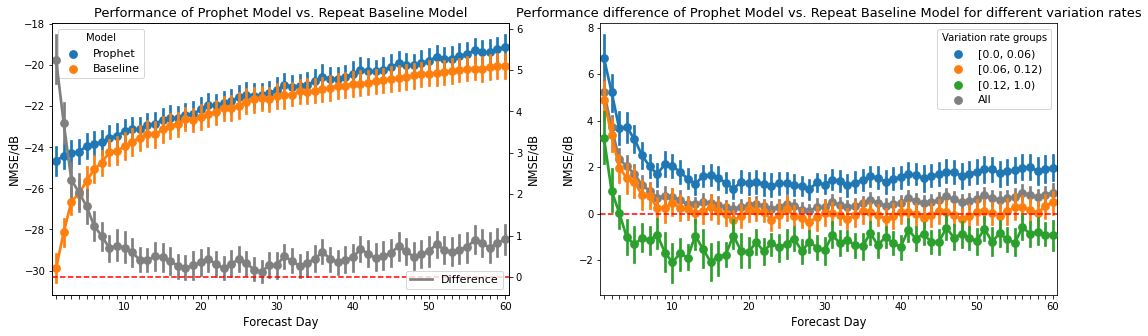

In [ ]:
fontsize = 13
set_fig_size((18, 5))
fig, axes = plt.subplots(1, 2)

performance_metrics_all_repeat["labels"] = performance_metrics_all_repeat["type"]
performance_metrics_all_repeat.labels = performance_metrics_all_repeat.labels.replace(to_replace="Repeat", value="Baseline").replace(to_replace="Not Lagged", value="Prophet")

# First subplot
p1 = sns.pointplot(data = performance_metrics_all_repeat[performance_metrics_all_repeat.type != "Diff"], x = "horizon_int", y = "nmse", hue = "labels", ax = axes[0])
ax0_2 = axes[0].twinx()
p1.set_title('Performance of Prophet Model vs. Repeat Baseline Model', fontsize = fontsize), p1.set_xlabel("Forecast Day", fontsize = fontsize - 1.5), p1.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p1.legend(title='Model', loc = "upper left", fontsize = fontsize - 2)
p2 = sns.pointplot(data = performance_metrics_all_repeat[performance_metrics_all_repeat.type == "Diff"], x = "horizon_int", y = "nmse", hue = "labels", ax = ax0_2, palette=['grey'])
p2.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p2.legend(title='', labels = ["Difference"], loc = "lower right", fontsize = fontsize - 2)
p2.axhline(0, color = "red", linestyle='--')
ticks = list(np.zeros(60))
for i in range(len(ticks)):
  if (i+1) % 10 == 0:
    ticks[i] = str(i + 1)
  else:
    ticks[i] = ""
p2.set_xticklabels(ticks)

# Second subplot
performance_metrics_all_repeat.labels = performance_metrics_all_repeat.labels.replace(to_replace="Diff", value="All").replace(to_replace="Not Lagged", value="Prophet")
performance_metrics_all_repeat["changes_samples_ratio_cat"] = pd.cut(performance_metrics_all_repeat["changes_samples_ratio"], bins = [0, 0.06, 0.12, 1], right = False)
p = sns.pointplot(data = performance_metrics_all_repeat[performance_metrics_all_repeat.type == "Diff"], x = "horizon_int", y = "nmse", hue = "changes_samples_ratio_cat", ax = axes[1])
p = sns.pointplot(data = performance_metrics_all_repeat[performance_metrics_all_repeat.type == "Diff"], x = "horizon_int", y = "nmse", hue = "labels", palette=['grey'], ax = axes[1])
p.axhline(0, color = "red", linestyle='--')
p.set_xticklabels(ticks)
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance difference of Prophet Model vs. Repeat Baseline Model for different variation rates", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Variation rate groups", fontsize = fontsize-2)

# Save fig
#save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "predictionPerformance1stProphetBaseline")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_prophet_predictionPerformance1stProphetBaselineAverage.


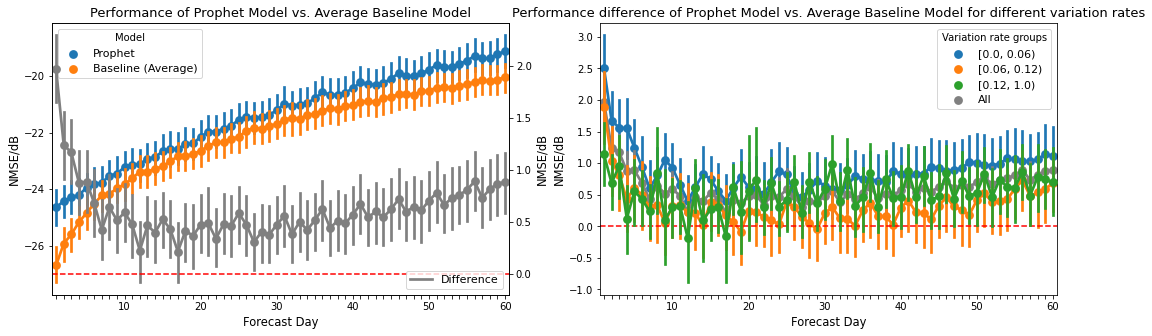

In [ ]:
fontsize = 13
set_fig_size((18, 5))
fig, axes = plt.subplots(1, 2)

performance_metrics_all_average["labels"] = performance_metrics_all_average["type"]
performance_metrics_all_average.labels = performance_metrics_all_average.labels.replace(to_replace="Repeat", value="Baseline").replace(to_replace="Not Lagged", value="Prophet")

# First subplot
p1 = sns.pointplot(data = performance_metrics_all_average[performance_metrics_all_average.type != "Diff Average"], x = "horizon_int", y = "nmse", hue = "labels", ax = axes[0])
ax0_2 = axes[0].twinx()
p1.set_title('Performance of Prophet Model vs. Average Baseline Model', fontsize = fontsize), p1.set_xlabel("Forecast Day", fontsize = fontsize - 1.5), p1.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p1.legend(title='Model', loc = "upper left", fontsize = fontsize - 2)
p2 = sns.pointplot(data = performance_metrics_all_average[performance_metrics_all_average.type == "Diff Average"], x = "horizon_int", y = "nmse", hue = "labels", ax = ax0_2, palette=['grey'])
p2.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p2.legend(title='', labels = ["Difference"], loc = "lower right", fontsize = fontsize - 2)
p2.axhline(0, color = "red", linestyle='--')
ticks = list(np.zeros(60))
for i in range(len(ticks)):
  if (i+1) % 10 == 0:
    ticks[i] = str(i + 1)
  else:
    ticks[i] = ""
p2.set_xticklabels(ticks)

# Second subplot
performance_metrics_all_average.labels = performance_metrics_all_average.labels.replace(to_replace="Diff Average", value="All").replace(to_replace="Not Lagged", value="Prophet")
performance_metrics_all_average["changes_samples_ratio_cat"] = pd.cut(performance_metrics_all_average["changes_samples_ratio"], bins = [0, 0.06, 0.12, 1], right = False)
p = sns.pointplot(data = performance_metrics_all_average[performance_metrics_all_average.type == "Diff Average"], x = "horizon_int", y = "nmse", hue = "changes_samples_ratio_cat", ax = axes[1])
p = sns.pointplot(data = performance_metrics_all_average[performance_metrics_all_average.type == "Diff Average"], x = "horizon_int", y = "nmse", hue = "labels", palette=['grey'], ax = axes[1])
p.axhline(0, color = "red", linestyle='--')
p.set_xticklabels(ticks)
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_title("Performance difference of Prophet Model vs. Average Baseline Model for different variation rates", fontsize = fontsize)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Variation rate groups", fontsize = fontsize-2)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "predictionPerformance1stProphetBaselineAverage")

In [ ]:
performance_metrics_all["changes_samples_ratio_cat"] = pd.cut(performance_metrics_all["changes_samples_ratio"], bins = [0, 0.06, 0.12, 1], right = False)


variations_categories = list(performance_metrics_all["changes_samples_ratio_cat"].unique().sort_values())
print(variations_categories)
anova_analysis_performance_metrics_high_variations = performance_metrics_all[performance_metrics_all.type == "Diff"]
anova_analysis_performance_metrics_high_variations = anova_analysis_performance_metrics_high_variations[anova_analysis_performance_metrics_high_variations["changes_samples_ratio_cat"] == variations_categories[-1]]
anova_analysis_performance_metrics_high_variations.groupby(by = "horizon_int")["nmse"].mean()
null_analysis = np.zeros(100)

anova_results = []
for horizon in range(1, 61):
  tmp = anova_analysis_performance_metrics_high_variations[anova_analysis_performance_metrics_high_variations.horizon_int == horizon]["nmse"]
  anova_results.append(f_oneway(tmp, np.zeros(len(tmp))))

pd.DataFrame(anova_results).pvalue < 0.05


[Interval(0.0, 0.06, closed='left'), Interval(0.06, 0.12, closed='left'), Interval(0.12, 1.0, closed='left')]


0      True
1      True
2     False
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46     True
47     True
48     True
49     True
50     True
51     True
52     True
53     True
54     True
55     True
56     True
57     True
58     True
59     True
Name: pvalue, dtype: bool

In [ ]:
# Verificou-se com que apenas com o changes_samples_ratio é que parece haver uma relação entre o nmse e o horizonte. Testaram-se outras coisas como a variância, nº de amostras, mas em nenhuma delas se verifica uma relação
# Pode-se então concluir que nas séries temporais onde ocorrem mais variações este modelo sai-se melhor que o repet. Tendo sido isto testado com validação cruzada, tornam-se resultados confiáveis.
# Isto pode também ser sumariado como, nas séries em que ocorrem mais variações, é mais provável o modelo repeat falhar na última previsão
# verifica-se que o balanço de hiper-parâmetros também se mantém constante

###### Compare performance of repeat model with model with univariate regressors

In [ ]:
def func_1(row, performance_metrics):
  tmp = row[performance_metrics].copy()
  tmp = tmp.iloc[:7][["horizon_int", "nmse"]]
  tmp["product_id"] = row.name
  return tmp

def func_2(df):
  
  nmse_repeat = df[df.model == "repeat"].nmse.values[0]
  nmse_lagged = df[df.model == "lagged"].nmse.values[0]
  nmse_not_lagged = df[df.model == "not lagged"].nmse.values[0]

  data = pd.DataFrame({'model': ["lagged", "not lagged"],
                       'diff_nmse': [nmse_lagged-nmse_repeat, nmse_not_lagged-nmse_repeat]})
  return data

In [ ]:
# Series with lagged univariate regressors
uni_predictions_lagged_horizon = uni_predictions_lagged[["product_id", "nmse", "prediction_horizon"]].copy()
uni_predictions_lagged_horizon["model"] = "lagged"
uni_predictions_lagged_horizon["horizon_int"] = uni_predictions_lagged_horizon["prediction_horizon"]
uni_predictions_lagged_horizon = uni_predictions_lagged_horizon.drop("prediction_horizon", axis = 1)

# Series without lagged univariate regressors
uni_predictions_not_lagged_horizon = pd.concat(list(pd.DataFrame(df_all_info_predictions.performance_metrics_w_nmse_not_lagged).apply(lambda row : func_1(row, "performance_metrics_w_nmse_not_lagged"), axis = 1)))
uni_predictions_not_lagged_horizon["model"] = "not lagged"

# Repeat
uni_predictions_repeat_horizon = pd.concat(list(pd.DataFrame(all_info_repeat.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
uni_predictions_repeat_horizon["model"] = "repeat"
uni_predictions_repeat_horizon = uni_predictions_repeat_horizon[uni_predictions_repeat_horizon.nmse > -500]

# # Join all
uni_predictions_horizon = pd.concat([uni_predictions_lagged_horizon, uni_predictions_not_lagged_horizon, uni_predictions_repeat_horizon]).reset_index(drop = True)
product_id_lst = uni_predictions_horizon.groupby(by = ["product_id", "horizon_int"]).size()
product_id_lst = list(product_id_lst[product_id_lst == 3].index.unique())
uni_predictions_horizon = uni_predictions_horizon.set_index(["product_id", "horizon_int"]).loc[product_id_lst]

# Add changes/samples
changes_samples = pd.concat([n_changes_flt, n_samples_flt, changes_samples_ratio], axis = 1)
changes_samples.columns = ["n_changes", "n_samples", "changes_samples_ratio"]
uni_predictions_horizon = uni_predictions_horizon.join(changes_samples, on = "product_id")

# Compare with repeat
compare_w_repeat = uni_predictions_horizon.groupby(by = ["product_id", "horizon_int"]).apply(func_2).reset_index().drop("level_2", axis = 1).set_index(["product_id", "horizon_int", "model"])
uni_predictions_horizon = uni_predictions_horizon.reset_index().set_index(["product_id", "horizon_int", "model"]).join(compare_w_repeat).reset_index()

NameError: ignored

In [ ]:
uni_predictions_horizon["changes_samples_ratio_cat"] = pd.cut(uni_predictions_horizon["changes_samples_ratio"], bins = [0, 0.06, 0.12, 1], right = False)

NameError: ignored

NameError: ignored

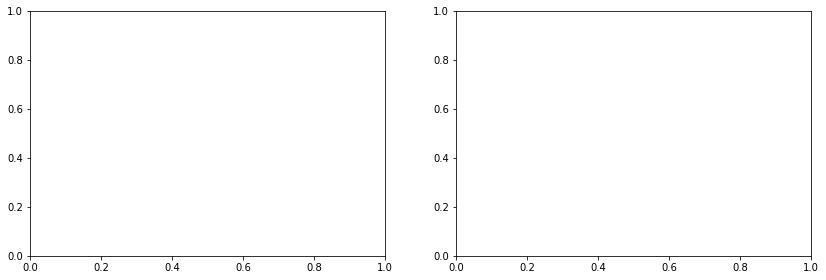

In [ ]:
# Previsão com lagged vai-se aproximando da outra pois há medida que o tempo passa a informação atualizada que temos é cada vez mais distante e um modelo acaba por convergir para o outro
fontsize = 13

set_fig_size((14, 4.5))
fig, ax = plt.subplots(1, 2)

uni_predictions_horizon["model_fixed"] = uni_predictions_horizon["model"].replace(to_replace=["lagged", "not lagged", "repeat"], value=["Prophet w/ regressors", "Prophet w/o regressors", "Baseline"])

p1 = sns.pointplot(data = uni_predictions_horizon, x = "horizon_int", y = "nmse", hue = "model_fixed", ax = ax[0], labels = ["Prophet w/ regressors", "Prophet w/o regressors", "Baseline"])
p1.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p1.set_title("Performance of Prophet Model vs. Baseline Model", fontsize = fontsize)
p1.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p1.legend(title = "Model")

p2 = sns.pointplot(data = uni_predictions_horizon, x = "horizon_int", y = "diff_nmse", hue = "model_fixed", ax = ax[1])
p2.axhline(0, color = "red", linestyle='--')
p2.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p2.set_title("Performance difference of Prophet Model vs. Baseline Model", fontsize = fontsize)
p2.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p2.legend(title = "Model")

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "prophet", name_of_fig = "predictionPerformance1stProphetBaselineLagged")